In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(2)])
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
out_flow = DFlow([LinearChol(n*dim[0]*dim[1], name='approx')])

In [8]:
outputs = tf.reshape(out_flow.output, [1, n, dim[0]*dim[1]])

In [9]:
prior = PWalk.logdens(outputs)

In [10]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [11]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [12]:
logl = create_loglik2()

In [13]:
ent = out_flow.logdens

In [14]:
ent

<tf.Tensor 'sub_1:0' shape=() dtype=float64>

In [15]:
df = dim[0]*dim[1]*5
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [16]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [17]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [18]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(-2658496.6709917434, -346.6856836290738, -2772.4231692980948)

In [22]:
loss.eval()

12652.879483862796

In [23]:
np.set_printoptions(precision=4)

In [24]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.0000e+04,  1.0931e+00, -5.3984e+00],
       [ 1.0931e+00,  1.0000e+04,  2.3170e+00],
       [-5.3984e+00,  2.3170e+00,  1.0000e+04]])

In [25]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

0.35695852679966056
[[16.5777  0.1642 -0.3625]
 [ 0.1642 17.0887 -1.2224]
 [-0.3625 -1.2224 13.8068]]


0.3726198549039658
[[16.593   0.1628 -0.3549]
 [ 0.1628 17.23   -1.2254]
 [-0.3549 -1.2254 13.7547]]


0.3496976487527238
[[16.5772  0.1633 -0.3609]
 [ 0.1633 17.0999 -1.2021]
 [-0.3609 -1.2021 13.7742]]


0.36906880224775507
[[16.5755  0.1547 -0.3436]
 [ 0.1547 17.1341 -1.1981]
 [-0.3436 -1.1981 13.7721]]


0.35962389605056605
[[16.5808  0.152  -0.3454]
 [ 0.152  17.1184 -1.2086]
 [-0.3454 -1.2086 13.7587]]


0.37318641447099615
[[16.2039  0.187  -0.336 ]
 [ 0.187  16.9968 -1.1768]
 [-0.336  -1.1768 13.5139]]


0.35227114978089585
[[16.1754  0.1955 -0.3249]
 [ 0.1955 16.9826 -1.1883]
 [-0.3249 -1.1883 13.5157]]


0.35231081493118105
[[16.2321  0.1976 -0.3343]
 [ 0.1976 17.0409 -1.184 ]
 [-0.3343 -1.184  13.5777]]


0.32784073038980216
[[16.2407  0.1849 -0.3414]
 [ 0.1849 16.9384 -1.1865]
 [-0.3414 -1.1865 13.5408]]


0.3593432056844955
[[16.328   0.1866 -0.3471]
 [ 0.1866 17.0349 -1

0.3450516133440123
[[16.1349  0.1384 -0.3621]
 [ 0.1384 16.8495 -1.1726]
 [-0.3621 -1.1726 13.3715]]


0.37539255067046373
[[16.2089  0.1377 -0.362 ]
 [ 0.1377 16.836  -1.1722]
 [-0.362  -1.1722 13.3952]]


0.38041748538261905
[[16.2428  0.1313 -0.3655]
 [ 0.1313 16.7416 -1.1597]
 [-0.3655 -1.1597 13.4337]]


0.380391206435923
[[16.1581  0.1373 -0.3599]
 [ 0.1373 16.7609 -1.1556]
 [-0.3599 -1.1556 13.4339]]


0.3497595103814913
[[16.1222  0.1358 -0.3566]
 [ 0.1358 16.821  -1.1606]
 [-0.3566 -1.1606 13.4332]]


0.37418409492193505
[[16.2806  0.1489 -0.3483]
 [ 0.1489 16.8326 -1.1649]
 [-0.3483 -1.1649 13.4924]]


0.35352163477018617
[[16.2521  0.1394 -0.3541]
 [ 0.1394 16.8346 -1.1548]
 [-0.3541 -1.1548 13.4552]]


0.37411480910383604
[[16.2442  0.1428 -0.3558]
 [ 0.1428 16.7957 -1.146 ]
 [-0.3558 -1.146  13.5243]]


0.35730081021946974
[[16.1717  0.155  -0.3452]
 [ 0.155  16.7199 -1.1513]
 [-0.3452 -1.1513 13.4909]]


0.34101149639285744
[[16.094   0.165  -0.3451]
 [ 0.165  16.6989 -1.

0.35053675531957496
[[15.994   0.1892 -0.3306]
 [ 0.1892 16.509  -1.1834]
 [-0.3306 -1.1834 13.3259]]


0.33059949402060007
[[15.9897  0.196  -0.3286]
 [ 0.196  16.619  -1.177 ]
 [-0.3286 -1.177  13.3354]]


0.3696755214638151
[[15.9805  0.185  -0.335 ]
 [ 0.185  16.7178 -1.1825]
 [-0.335  -1.1825 13.3391]]


0.36991571660953054
[[16.0465  0.1899 -0.3368]
 [ 0.1899 16.5977 -1.1906]
 [-0.3368 -1.1906 13.3595]]


0.35102171414947636
[[16.0445  0.1878 -0.3237]
 [ 0.1878 16.614  -1.1886]
 [-0.3237 -1.1886 13.3253]]


0.38182497417514366
[[15.9691  0.1907 -0.3099]
 [ 0.1907 16.5212 -1.1896]
 [-0.3099 -1.1896 13.3625]]


0.3501230581139931
[[16.085   0.1911 -0.3259]
 [ 0.1911 16.5184 -1.1878]
 [-0.3259 -1.1878 13.2451]]


0.37491131647311277
[[16.1653  0.1878 -0.3418]
 [ 0.1878 16.5387 -1.1982]
 [-0.3418 -1.1982 13.2898]]


0.37678218645675143
[[16.1526  0.1931 -0.3421]
 [ 0.1931 16.6576 -1.2153]
 [-0.3421 -1.2153 13.228 ]]


0.3715775635356407
[[16.1069  0.199  -0.345 ]
 [ 0.199  16.647  -1

0.4288909278708392
[[16.0596  0.1664 -0.2994]
 [ 0.1664 16.4938 -1.1458]
 [-0.2994 -1.1458 13.1434]]


0.33704152299149814
[[16.0709  0.161  -0.2993]
 [ 0.161  16.5278 -1.138 ]
 [-0.2993 -1.138  13.0899]]


0.3349984992008499
[[16.0278  0.1698 -0.3033]
 [ 0.1698 16.5767 -1.1401]
 [-0.3033 -1.1401 13.137 ]]


0.35928093005941886
[[15.9842  0.1736 -0.2901]
 [ 0.1736 16.6231 -1.149 ]
 [-0.2901 -1.149  13.1769]]


0.32805515486672826
[[16.0708  0.1778 -0.2905]
 [ 0.1778 16.6285 -1.1483]
 [-0.2905 -1.1483 13.1672]]


0.36639564675842257
[[16.0026  0.1791 -0.2814]
 [ 0.1791 16.4786 -1.1415]
 [-0.2814 -1.1415 13.1842]]


0.3747177974270807
[[16.0128  0.1771 -0.2928]
 [ 0.1771 16.4448 -1.1424]
 [-0.2928 -1.1424 13.2066]]


0.3797995220923378
[[16.0082  0.1692 -0.2989]
 [ 0.1692 16.4669 -1.1378]
 [-0.2989 -1.1378 13.2962]]


0.37064854569381217
[[16.0528  0.1673 -0.2988]
 [ 0.1673 16.5716 -1.1282]
 [-0.2988 -1.1282 13.2583]]


0.3871123195205926
[[16.0783  0.1685 -0.2987]
 [ 0.1685 16.5627 -1.1

0.3849583062283121
[[16.0221  0.1444 -0.3334]
 [ 0.1444 16.4403 -1.155 ]
 [-0.3334 -1.155  13.0554]]


0.35652659147135074
[[15.9838  0.1455 -0.3321]
 [ 0.1455 16.4312 -1.1582]
 [-0.3321 -1.1582 13.0878]]


0.38928025170399805
[[15.9337  0.1447 -0.3366]
 [ 0.1447 16.467  -1.1686]
 [-0.3366 -1.1686 13.0535]]


0.35831953143639894
[[15.8513  0.1503 -0.344 ]
 [ 0.1503 16.472  -1.1751]
 [-0.344  -1.1751 13.1189]]


0.37488929138946075
[[15.8857  0.1511 -0.3447]
 [ 0.1511 16.4526 -1.1832]
 [-0.3447 -1.1832 13.0885]]


0.34871212375239524
[[15.8206  0.1511 -0.3476]
 [ 0.1511 16.4214 -1.1761]
 [-0.3476 -1.1761 13.1131]]


0.3348440834693346
[[15.7268  0.1454 -0.3416]
 [ 0.1454 16.3665 -1.1825]
 [-0.3416 -1.1825 13.183 ]]


0.3391038338880025
[[15.7138  0.1483 -0.3318]
 [ 0.1483 16.3738 -1.1674]
 [-0.3318 -1.1674 13.1169]]


0.35208370925714655
[[15.6854  0.1476 -0.3225]
 [ 0.1476 16.3847 -1.165 ]
 [-0.3225 -1.165  13.0352]]


0.35950398960619767
[[15.6591  0.1566 -0.3255]
 [ 0.1566 16.4309 -1

0.39965579406005153
[[15.7655  0.1384 -0.2896]
 [ 0.1384 16.2636 -1.1383]
 [-0.2896 -1.1383 13.0202]]


0.3537477308546684
[[15.7368  0.137  -0.305 ]
 [ 0.137  16.1509 -1.1287]
 [-0.305  -1.1287 13.0051]]


0.37837196382436716
[[15.7643  0.1241 -0.3061]
 [ 0.1241 16.1249 -1.1264]
 [-0.3061 -1.1264 12.952 ]]


0.3573940783598292
[[15.7698  0.115  -0.3072]
 [ 0.115  16.2003 -1.1265]
 [-0.3072 -1.1265 13.0568]]


0.3692703077924747
[[15.7822  0.119  -0.3034]
 [ 0.119  16.1132 -1.1268]
 [-0.3034 -1.1268 12.9948]]


0.36423260837850485
[[15.7984  0.116  -0.3061]
 [ 0.116  16.0666 -1.1319]
 [-0.3061 -1.1319 13.0399]]


0.34132666976292053
[[15.7634  0.1166 -0.3138]
 [ 0.1166 16.0684 -1.1357]
 [-0.3138 -1.1357 13.0003]]


0.3652935384755345
[[15.7872  0.1162 -0.3196]
 [ 0.1162 16.0887 -1.1401]
 [-0.3196 -1.1401 12.9664]]


0.33605915129185904
[[15.8087  0.1163 -0.3263]
 [ 0.1163 16.0911 -1.1383]
 [-0.3263 -1.1383 12.9942]]


0.3418014764517488
[[15.7844  0.1086 -0.3383]
 [ 0.1086 16.0828 -1.1

0.35061296979619033
[[15.6571  0.1671 -0.3098]
 [ 0.1671 16.179  -1.1279]
 [-0.3098 -1.1279 12.925 ]]


0.380117291186178
[[15.5433  0.1577 -0.3151]
 [ 0.1577 16.1342 -1.1216]
 [-0.3151 -1.1216 12.8714]]


0.36174704795793927
[[15.5842  0.1471 -0.3181]
 [ 0.1471 16.0759 -1.1191]
 [-0.3181 -1.1191 12.8596]]


0.37615732972658833
[[15.6293  0.1501 -0.3083]
 [ 0.1501 16.1297 -1.1348]
 [-0.3083 -1.1348 12.8524]]


0.34661886589116087
[[15.6929  0.1551 -0.324 ]
 [ 0.1551 16.0559 -1.1327]
 [-0.324  -1.1327 12.9109]]


0.3557834561100973
[[15.8042  0.1624 -0.3152]
 [ 0.1624 16.0499 -1.1381]
 [-0.3152 -1.1381 12.8473]]


0.34657256646675655
[[15.673   0.1774 -0.3262]
 [ 0.1774 16.023  -1.1372]
 [-0.3262 -1.1372 12.8087]]


0.3366198199596605
[[15.6268  0.1695 -0.3356]
 [ 0.1695 16.1462 -1.1461]
 [-0.3356 -1.1461 12.85  ]]


0.3356462228309077
[[15.7084  0.1665 -0.3345]
 [ 0.1665 16.1796 -1.1521]
 [-0.3345 -1.1521 12.8801]]


0.37575202140101904
[[15.727   0.1569 -0.3236]
 [ 0.1569 16.1603 -1.1

0.32274441516011837
[[15.4936  0.156  -0.276 ]
 [ 0.156  16.067  -1.1594]
 [-0.276  -1.1594 12.8439]]


0.37979674283174497
[[15.4484  0.1454 -0.2813]
 [ 0.1454 16.1033 -1.1467]
 [-0.2813 -1.1467 12.8036]]


0.346699517311758
[[15.4662  0.1489 -0.2958]
 [ 0.1489 16.0972 -1.1426]
 [-0.2958 -1.1426 12.8154]]


0.3423921349717342
[[15.4708  0.142  -0.2937]
 [ 0.142  16.1167 -1.1255]
 [-0.2937 -1.1255 12.801 ]]


0.3866111506334004
[[15.5029  0.1501 -0.2867]
 [ 0.1501 16.071  -1.1258]
 [-0.2867 -1.1258 12.7815]]


0.3778086408735814
[[15.4312  0.1517 -0.2915]
 [ 0.1517 16.057  -1.1309]
 [-0.2915 -1.1309 12.8256]]


0.34706018890918694
[[15.4788  0.1502 -0.2949]
 [ 0.1502 15.9467 -1.1246]
 [-0.2949 -1.1246 12.7901]]


0.3767381001779443
[[15.5366  0.1543 -0.302 ]
 [ 0.1543 15.8173 -1.1075]
 [-0.302  -1.1075 12.7563]]


0.3718053192107559
[[15.5908  0.1527 -0.3024]
 [ 0.1527 15.7505 -1.1077]
 [-0.3024 -1.1077 12.7327]]


0.36908052694024795
[[15.6184  0.1405 -0.311 ]
 [ 0.1405 15.7988 -1.117

0.35502140018693484
[[15.4154  0.1665 -0.2975]
 [ 0.1665 15.8638 -1.1397]
 [-0.2975 -1.1397 12.6837]]


0.3688348214709733
[[15.4483  0.1693 -0.2954]
 [ 0.1693 15.8881 -1.1414]
 [-0.2954 -1.1414 12.756 ]]


0.3291186995396506
[[15.4366  0.1554 -0.2896]
 [ 0.1554 15.9231 -1.1351]
 [-0.2896 -1.1351 12.7349]]


0.3512163988940729
[[15.5033  0.1629 -0.2832]
 [ 0.1629 15.8733 -1.1414]
 [-0.2832 -1.1414 12.7392]]


0.3756286931812544
[[15.568   0.1592 -0.2749]
 [ 0.1592 15.8299 -1.1419]
 [-0.2749 -1.1419 12.7338]]


0.35659858006250367
[[15.5169  0.1715 -0.2712]
 [ 0.1715 15.8431 -1.1576]
 [-0.2712 -1.1576 12.7575]]


0.3882286590203136
[[15.4876  0.1718 -0.2781]
 [ 0.1718 15.7382 -1.1392]
 [-0.2781 -1.1392 12.743 ]]


0.34943606415244327
[[15.5352  0.1743 -0.2853]
 [ 0.1743 15.8105 -1.147 ]
 [-0.2853 -1.147  12.7426]]


0.3528026550543987
[[15.4981  0.1748 -0.2976]
 [ 0.1748 15.821  -1.1285]
 [-0.2976 -1.1285 12.7559]]


0.333824417660986
[[15.47    0.1783 -0.3028]
 [ 0.1783 15.7975 -1.132 

0.3490649045213473
[[15.4897  0.1858 -0.2767]
 [ 0.1858 15.7147 -1.126 ]
 [-0.2767 -1.126  12.6079]]


0.3758152410053317
[[15.4786  0.1768 -0.2875]
 [ 0.1768 15.7394 -1.1298]
 [-0.2875 -1.1298 12.71  ]]


0.36233544315743504
[[15.5513  0.1714 -0.2722]
 [ 0.1714 15.8443 -1.1359]
 [-0.2722 -1.1359 12.6506]]


0.3698623889843621
[[15.5065  0.1673 -0.2834]
 [ 0.1673 15.7875 -1.1373]
 [-0.2834 -1.1373 12.6231]]


0.3894866082875313
[[15.4657  0.1685 -0.2742]
 [ 0.1685 15.8054 -1.1348]
 [-0.2742 -1.1348 12.6202]]


0.3783117967087352
[[15.5015  0.1793 -0.274 ]
 [ 0.1793 15.8758 -1.1253]
 [-0.274  -1.1253 12.5876]]


0.38097320550818736
[[15.4561  0.1601 -0.2812]
 [ 0.1601 15.9096 -1.1273]
 [-0.2812 -1.1273 12.5571]]


0.3430793301982534
[[15.5085  0.1647 -0.2861]
 [ 0.1647 15.8234 -1.1203]
 [-0.2861 -1.1203 12.5601]]


0.37036560780266986
[[15.4098  0.1672 -0.2697]
 [ 0.1672 15.8742 -1.1285]
 [-0.2697 -1.1285 12.5343]]


0.3380810292395881
[[15.2942  0.1619 -0.2685]
 [ 0.1619 15.8834 -1.133

0.369479652254571
[[15.1985  0.182  -0.3118]
 [ 0.182  15.8672 -1.1557]
 [-0.3118 -1.1557 12.6097]]


0.37864334684337647
[[15.218   0.1878 -0.3048]
 [ 0.1878 15.8423 -1.1507]
 [-0.3048 -1.1507 12.6006]]


0.36053355342137067
[[15.2437  0.1844 -0.2944]
 [ 0.1844 15.8811 -1.1527]
 [-0.2944 -1.1527 12.6254]]


0.3691046432935475
[[15.2705  0.1857 -0.2954]
 [ 0.1857 15.9151 -1.1567]
 [-0.2954 -1.1567 12.5931]]


0.3284022721022025
[[15.1612  0.1814 -0.291 ]
 [ 0.1814 15.8029 -1.1579]
 [-0.291  -1.1579 12.6008]]


0.3450150649530021
[[15.1707  0.1838 -0.2957]
 [ 0.1838 15.8321 -1.1501]
 [-0.2957 -1.1501 12.5722]]


0.35357201732399407
[[15.2356  0.1777 -0.2976]
 [ 0.1777 15.8226 -1.1539]
 [-0.2976 -1.1539 12.6011]]


0.34476080929954495
[[15.2739  0.1797 -0.2928]
 [ 0.1797 15.8202 -1.1432]
 [-0.2928 -1.1432 12.6596]]


0.33993368544750946
[[15.3656  0.1653 -0.2937]
 [ 0.1653 15.8161 -1.1416]
 [-0.2937 -1.1416 12.6997]]


0.37231507790705703
[[15.3771  0.1576 -0.3053]
 [ 0.1576 15.8622 -1.1

0.3469150865736104
[[15.3176  0.1345 -0.3102]
 [ 0.1345 15.5348 -1.1385]
 [-0.3102 -1.1385 12.4694]]


0.35940351203848486
[[15.2337  0.1385 -0.2999]
 [ 0.1385 15.5385 -1.1497]
 [-0.2999 -1.1497 12.4321]]


0.3554819715765129
[[15.2153  0.1282 -0.2952]
 [ 0.1282 15.6118 -1.1532]
 [-0.2952 -1.1532 12.4242]]


0.3452961157420269
[[15.1885  0.1175 -0.3076]
 [ 0.1175 15.672  -1.1609]
 [-0.3076 -1.1609 12.4783]]


0.35411518585182145
[[15.1892  0.131  -0.2938]
 [ 0.131  15.6829 -1.1593]
 [-0.2938 -1.1593 12.4763]]


0.38592256533272956
[[15.0759  0.1313 -0.2808]
 [ 0.1313 15.6066 -1.1642]
 [-0.2808 -1.1642 12.4975]]


0.3776657926282013
[[15.1026  0.1472 -0.2733]
 [ 0.1472 15.6741 -1.1646]
 [-0.2733 -1.1646 12.4662]]


0.36219758454224477
[[15.2034  0.1446 -0.2715]
 [ 0.1446 15.647  -1.1622]
 [-0.2715 -1.1622 12.4828]]


0.3574316300430881
[[15.2602  0.141  -0.2875]
 [ 0.141  15.6772 -1.1687]
 [-0.2875 -1.1687 12.5169]]


0.3790907912518014
[[15.2987  0.1332 -0.2841]
 [ 0.1332 15.7383 -1.16

0.3815636218332188
[[15.1045  0.2282 -0.2631]
 [ 0.2282 15.4672 -1.1619]
 [-0.2631 -1.1619 12.3135]]


0.40526881420098143
[[15.0998  0.2291 -0.2742]
 [ 0.2291 15.5285 -1.1565]
 [-0.2742 -1.1565 12.3369]]


0.3831455723288259
[[15.2201  0.2173 -0.2682]
 [ 0.2173 15.4924 -1.1611]
 [-0.2682 -1.1611 12.2668]]


0.3573542724924569
[[15.2648  0.2195 -0.2737]
 [ 0.2195 15.3738 -1.1586]
 [-0.2737 -1.1586 12.3063]]


0.347173286146606
[[15.2813  0.2163 -0.273 ]
 [ 0.2163 15.3634 -1.1482]
 [-0.273  -1.1482 12.325 ]]


0.3685965735311119
[[15.3128  0.2239 -0.2663]
 [ 0.2239 15.41   -1.1608]
 [-0.2663 -1.1608 12.3209]]


0.39381377350167207
[[15.2477  0.2022 -0.2683]
 [ 0.2022 15.3774 -1.1667]
 [-0.2683 -1.1667 12.3388]]


0.3418711563705
[[15.195   0.2063 -0.2777]
 [ 0.2063 15.3973 -1.1799]
 [-0.2777 -1.1799 12.3316]]


0.34961346596999865
[[15.1319  0.2097 -0.2674]
 [ 0.2097 15.4855 -1.1844]
 [-0.2674 -1.1844 12.369 ]]


0.3840699486996671
[[15.0228  0.2012 -0.2642]
 [ 0.2012 15.5929 -1.1914]
 

0.35244009924967096
[[15.1497  0.1704 -0.2694]
 [ 0.1704 15.5118 -1.1339]
 [-0.2694 -1.1339 12.3232]]


0.32264399766126645
[[15.1088  0.1735 -0.2724]
 [ 0.1735 15.4559 -1.1284]
 [-0.2724 -1.1284 12.2719]]


0.3768360290200389
[[15.1751  0.1683 -0.2674]
 [ 0.1683 15.4129 -1.1407]
 [-0.2674 -1.1407 12.3311]]


0.36576332567466824
[[15.1966  0.1743 -0.2664]
 [ 0.1743 15.3563 -1.1391]
 [-0.2664 -1.1391 12.3258]]


0.3465876379502491
[[15.1494  0.1929 -0.2604]
 [ 0.1929 15.4165 -1.141 ]
 [-0.2604 -1.141  12.2992]]


0.36917834069577243
[[15.1917  0.1971 -0.2642]
 [ 0.1971 15.3637 -1.1318]
 [-0.2642 -1.1318 12.2917]]


0.3529947286679485
[[15.1158  0.1811 -0.2536]
 [ 0.1811 15.4539 -1.1549]
 [-0.2536 -1.1549 12.1678]]


0.31009276619819665
[[15.1218  0.1798 -0.2534]
 [ 0.1798 15.4408 -1.1474]
 [-0.2534 -1.1474 12.2261]]


0.37480206694836
[[15.1076  0.1781 -0.2552]
 [ 0.1781 15.4393 -1.1441]
 [-0.2552 -1.1441 12.2182]]


0.36916997584115957
[[15.1313  0.1733 -0.2682]
 [ 0.1733 15.4117 -1.14

0.3372416019943021
[[14.9169  0.1978 -0.2897]
 [ 0.1978 15.405  -1.1239]
 [-0.2897 -1.1239 12.2331]]


0.36668648324973324
[[14.9904  0.1962 -0.2784]
 [ 0.1962 15.3477 -1.1249]
 [-0.2784 -1.1249 12.2718]]


0.3483317195735653
[[15.0351  0.1827 -0.2817]
 [ 0.1827 15.3904 -1.1313]
 [-0.2817 -1.1313 12.1989]]


0.364549712369775
[[15.001   0.1854 -0.3016]
 [ 0.1854 15.3698 -1.1353]
 [-0.3016 -1.1353 12.2429]]


0.36531988668569876
[[15.0316  0.1905 -0.3   ]
 [ 0.1905 15.3263 -1.1315]
 [-0.3    -1.1315 12.3436]]


0.3829891400844481
[[15.097   0.1723 -0.2966]
 [ 0.1723 15.3133 -1.1333]
 [-0.2966 -1.1333 12.298 ]]


0.36890441552670317
[[15.1012  0.1723 -0.3002]
 [ 0.1723 15.3719 -1.1375]
 [-0.3002 -1.1375 12.2982]]


0.38708864426933964
[[15.0207  0.1746 -0.2982]
 [ 0.1746 15.4052 -1.1328]
 [-0.2982 -1.1328 12.2367]]


0.32699676978185827
[[15.0064  0.1872 -0.2871]
 [ 0.1872 15.3403 -1.1334]
 [-0.2871 -1.1334 12.2888]]


0.37109933641243203
[[15.0205  0.188  -0.2829]
 [ 0.188  15.2848 -1.1

0.33245253239122097
[[15.0286  0.1994 -0.2667]
 [ 0.1994 15.1702 -1.1419]
 [-0.2667 -1.1419 12.2427]]


0.4020190402093617
[[14.9456  0.2033 -0.2708]
 [ 0.2033 15.249  -1.1388]
 [-0.2708 -1.1388 12.2569]]


0.369308815528715
[[14.9989  0.1915 -0.2655]
 [ 0.1915 15.2554 -1.1378]
 [-0.2655 -1.1378 12.1658]]


0.3502362544930989
[[15.091   0.2021 -0.2716]
 [ 0.2021 15.2827 -1.1405]
 [-0.2716 -1.1405 12.1893]]


0.34913944854055834
[[14.9842  0.1943 -0.2692]
 [ 0.1943 15.2072 -1.1398]
 [-0.2692 -1.1398 12.2036]]


0.37611618488157184
[[14.9311  0.1921 -0.2624]
 [ 0.1921 15.1991 -1.1382]
 [-0.2624 -1.1382 12.1974]]


0.35346537717651444
[[14.9077  0.1889 -0.2695]
 [ 0.1889 15.1986 -1.1373]
 [-0.2695 -1.1373 12.2124]]


0.38351437402345234
[[14.884   0.1888 -0.2655]
 [ 0.1888 15.2045 -1.1282]
 [-0.2655 -1.1282 12.2044]]


0.35815657175210985
[[14.8888  0.1931 -0.2661]
 [ 0.1931 15.2526 -1.1314]
 [-0.2661 -1.1314 12.1852]]


0.3773091117951963
[[14.9046  0.1968 -0.2712]
 [ 0.1968 15.2877 -1.1

0.3623775207954073
[[14.8502  0.1746 -0.2755]
 [ 0.1746 15.2805 -1.1577]
 [-0.2755 -1.1577 12.1028]]


0.4021259093285012
[[14.812   0.1662 -0.2654]
 [ 0.1662 15.185  -1.1581]
 [-0.2654 -1.1581 12.1416]]


0.3374754440131534
[[14.8294  0.1576 -0.2656]
 [ 0.1576 15.2525 -1.1574]
 [-0.2656 -1.1574 12.1085]]


0.3758238910923752
[[14.7943  0.1587 -0.2585]
 [ 0.1587 15.2902 -1.1636]
 [-0.2585 -1.1636 12.1403]]


0.35839666934121134
[[14.7441  0.161  -0.2669]
 [ 0.161  15.3093 -1.1717]
 [-0.2669 -1.1717 12.2166]]


0.3993705773788035
[[14.7161  0.1756 -0.2702]
 [ 0.1756 15.2097 -1.1696]
 [-0.2702 -1.1696 12.179 ]]


0.34752667836978407
[[14.7508  0.1779 -0.2779]
 [ 0.1779 15.2064 -1.1773]
 [-0.2779 -1.1773 12.1822]]


0.3844708203335096
[[14.7791  0.1649 -0.2725]
 [ 0.1649 15.1872 -1.1835]
 [-0.2725 -1.1835 12.2266]]


0.3523432672758697
[[14.8924  0.1604 -0.2749]
 [ 0.1604 15.209  -1.1777]
 [-0.2749 -1.1777 12.2432]]


0.38558558711583496
[[14.8167  0.1708 -0.282 ]
 [ 0.1708 15.2016 -1.169

0.36615864777382484
[[14.7616  0.193  -0.2416]
 [ 0.193  15.1503 -1.1615]
 [-0.2416 -1.1615 12.1303]]


0.3773026601285051
[[14.7683  0.1934 -0.2381]
 [ 0.1934 15.2004 -1.1624]
 [-0.2381 -1.1624 12.0603]]


0.3445620217469966
[[14.7663  0.2004 -0.2364]
 [ 0.2004 15.1618 -1.1615]
 [-0.2364 -1.1615 12.106 ]]


0.339846529477767
[[14.7174  0.1863 -0.2458]
 [ 0.1863 15.1763 -1.1685]
 [-0.2458 -1.1685 12.0991]]


0.34314352570813167
[[14.7702  0.1814 -0.2605]
 [ 0.1814 15.1363 -1.1649]
 [-0.2605 -1.1649 12.0929]]


0.3725489144750688
[[14.7283  0.1876 -0.2581]
 [ 0.1876 15.1846 -1.1699]
 [-0.2581 -1.1699 12.146 ]]


0.3761922272826068
[[14.7316  0.1758 -0.2542]
 [ 0.1758 15.207  -1.1612]
 [-0.2542 -1.1612 12.1318]]


0.37501886173332977
[[14.8396  0.1745 -0.2515]
 [ 0.1745 15.1981 -1.1544]
 [-0.2515 -1.1544 12.1972]]


0.3560397254141708
[[14.8214  0.1716 -0.2519]
 [ 0.1716 15.1934 -1.1505]
 [-0.2519 -1.1505 12.2031]]


0.34746310497217436
[[14.6894  0.173  -0.2483]
 [ 0.173  15.1363 -1.144

0.35460105416350607
[[14.6944  0.2019 -0.2487]
 [ 0.2019 15.0741 -1.1808]
 [-0.2487 -1.1808 12.0334]]


0.38531471343546075
[[14.6483  0.1911 -0.2531]
 [ 0.1911 15.0264 -1.1636]
 [-0.2531 -1.1636 12.0327]]


0.3816138902521899
[[14.5884  0.1913 -0.2532]
 [ 0.1913 15.0481 -1.1551]
 [-0.2532 -1.1551 12.0066]]


0.3746057991867371
[[14.6789  0.1932 -0.2547]
 [ 0.1932 15.012  -1.1546]
 [-0.2547 -1.1546 12.0724]]


0.367516116959654
[[14.6807  0.1846 -0.2576]
 [ 0.1846 14.9474 -1.1536]
 [-0.2576 -1.1536 12.1023]]


0.3701029662816049
[[14.7207  0.173  -0.2489]
 [ 0.173  14.9989 -1.1461]
 [-0.2489 -1.1461 12.0263]]


0.37592946265905863
[[14.7063  0.1755 -0.2526]
 [ 0.1755 14.9916 -1.1486]
 [-0.2526 -1.1486 11.9581]]


0.3367747363419621
[[14.6992  0.1826 -0.2502]
 [ 0.1826 15.0158 -1.1521]
 [-0.2502 -1.1521 11.9694]]


0.3653539107334774
[[14.7364  0.1824 -0.2494]
 [ 0.1824 15.0238 -1.1464]
 [-0.2494 -1.1464 12.0282]]


0.37785655608231145
[[14.7411  0.1811 -0.2492]
 [ 0.1811 15.0871 -1.139

0.36636916799999586
[[14.6254  0.1934 -0.2516]
 [ 0.1934 15.015  -1.141 ]
 [-0.2516 -1.141  11.8536]]


0.3719010446705041
[[14.6891  0.1912 -0.2653]
 [ 0.1912 14.9424 -1.1418]
 [-0.2653 -1.1418 11.883 ]]


0.3565170021262054
[[14.7091  0.2033 -0.2593]
 [ 0.2033 14.987  -1.1435]
 [-0.2593 -1.1435 11.9934]]


0.3221744108305147
[[14.6893  0.1992 -0.2563]
 [ 0.1992 15.0382 -1.1421]
 [-0.2563 -1.1421 11.9839]]


0.3506470775211995
[[14.5713  0.1964 -0.2558]
 [ 0.1964 15.0669 -1.1462]
 [-0.2558 -1.1462 11.9911]]


0.3547481375026745
[[14.5092  0.1989 -0.2507]
 [ 0.1989 15.0162 -1.1324]
 [-0.2507 -1.1324 11.9902]]


0.37714346924032244
[[14.5984  0.1895 -0.2539]
 [ 0.1895 15.0228 -1.122 ]
 [-0.2539 -1.122  11.9176]]


0.32629896922711316
[[14.6293  0.1722 -0.2521]
 [ 0.1722 14.9669 -1.1278]
 [-0.2521 -1.1278 11.8844]]


0.3354522110030012
[[14.5853  0.1828 -0.2547]
 [ 0.1828 14.8594 -1.1283]
 [-0.2547 -1.1283 11.905 ]]


0.37381051718652686
[[14.5791  0.1885 -0.2548]
 [ 0.1885 14.8731 -1.11

0.3429365064007001
[[14.6136  0.1811 -0.2363]
 [ 0.1811 14.7005 -1.0925]
 [-0.2363 -1.0925 11.8431]]


0.360917387077759
[[14.6323  0.1747 -0.2502]
 [ 0.1747 14.7576 -1.1088]
 [-0.2502 -1.1088 11.8176]]


0.37162289933449627
[[14.6189  0.1811 -0.2464]
 [ 0.1811 14.8097 -1.1066]
 [-0.2464 -1.1066 11.8438]]


0.3832818334349605
[[14.5881  0.185  -0.2511]
 [ 0.185  14.7717 -1.1062]
 [-0.2511 -1.1062 11.8567]]


0.35522792563376104
[[14.5776  0.1798 -0.2552]
 [ 0.1798 14.7899 -1.1016]
 [-0.2552 -1.1016 11.8747]]


0.3530933264936323
[[14.5608  0.1817 -0.2517]
 [ 0.1817 14.7502 -1.0937]
 [-0.2517 -1.0937 11.9156]]


0.3462776642370705
[[14.5319  0.1835 -0.2447]
 [ 0.1835 14.8067 -1.0909]
 [-0.2447 -1.0909 11.9193]]


0.3438016117315336
[[14.547   0.1774 -0.2461]
 [ 0.1774 14.8601 -1.0997]
 [-0.2461 -1.0997 11.9031]]


0.34538075969887655
[[14.6964  0.1748 -0.2544]
 [ 0.1748 14.9359 -1.1057]
 [-0.2544 -1.1057 11.9119]]


0.35593685128778907
[[14.6816  0.1657 -0.2521]
 [ 0.1657 14.9086 -1.111

0.34951170431323736
[[14.6856  0.1855 -0.2151]
 [ 0.1855 15.0214 -1.1464]
 [-0.2151 -1.1464 11.9576]]


0.3501558157312585
[[14.6869  0.1899 -0.2151]
 [ 0.1899 14.9574 -1.1459]
 [-0.2151 -1.1459 11.9637]]


0.36269091558529853
[[14.6733  0.1943 -0.231 ]
 [ 0.1943 14.9049 -1.1529]
 [-0.231  -1.1529 11.9066]]


0.35586480342432336
[[14.6174  0.2051 -0.2308]
 [ 0.2051 14.912  -1.1496]
 [-0.2308 -1.1496 11.8149]]


0.3612133402059913
[[14.5739  0.1913 -0.237 ]
 [ 0.1913 14.9995 -1.1656]
 [-0.237  -1.1656 11.8278]]


0.3699413706840418
[[14.6893  0.1947 -0.2362]
 [ 0.1947 14.9569 -1.1588]
 [-0.2362 -1.1588 11.8566]]


0.36418609999643464
[[14.672   0.1903 -0.2257]
 [ 0.1903 14.856  -1.1565]
 [-0.2257 -1.1565 11.8903]]


0.3693824860237443
[[14.5495  0.1969 -0.2277]
 [ 0.1969 14.8623 -1.1579]
 [-0.2277 -1.1579 11.9348]]


0.3503301506234981
[[14.5918  0.195  -0.2204]
 [ 0.195  14.8857 -1.1527]
 [-0.2204 -1.1527 11.9744]]


0.3765778531068898
[[14.6128  0.1853 -0.2323]
 [ 0.1853 14.9212 -1.14

0.360370222912382
[[14.6699  0.2286 -0.2367]
 [ 0.2286 14.7459 -1.1603]
 [-0.2367 -1.1603 11.8126]]


0.3445178977569732
[[14.6478  0.2231 -0.2276]
 [ 0.2231 14.7543 -1.1666]
 [-0.2276 -1.1666 11.7904]]


0.3961107820513731
[[14.6579  0.2167 -0.2307]
 [ 0.2167 14.7818 -1.1709]
 [-0.2307 -1.1709 11.8444]]


0.3498618079899171
[[14.6343  0.2056 -0.2401]
 [ 0.2056 14.6464 -1.1646]
 [-0.2401 -1.1646 11.8674]]


0.34660308225711617
[[14.5684  0.2006 -0.245 ]
 [ 0.2006 14.723  -1.1605]
 [-0.245  -1.1605 11.882 ]]


0.35517272111790227
[[14.6169  0.1927 -0.2391]
 [ 0.1927 14.7884 -1.1604]
 [-0.2391 -1.1604 11.8385]]


0.35639958742953726
[[14.5424  0.2011 -0.2456]
 [ 0.2011 14.8101 -1.1634]
 [-0.2456 -1.1634 11.8376]]


0.35882412583819046
[[14.4795  0.1913 -0.2461]
 [ 0.1913 14.8712 -1.1655]
 [-0.2461 -1.1655 11.7766]]


0.3609798889998268
[[14.469   0.2041 -0.2357]
 [ 0.2041 14.9057 -1.1654]
 [-0.2357 -1.1654 11.7418]]


0.3708431159762259
[[14.4144  0.211  -0.2362]
 [ 0.211  14.8762 -1.173

0.3438497123887745
[[14.5513  0.1714 -0.2342]
 [ 0.1714 14.6998 -1.1338]
 [-0.2342 -1.1338 11.6831]]


0.3488805502306231
[[14.5403  0.1701 -0.2294]
 [ 0.1701 14.6655 -1.1372]
 [-0.2294 -1.1372 11.6475]]


0.38372103717944284
[[14.5147  0.1799 -0.2392]
 [ 0.1799 14.7484 -1.1387]
 [-0.2392 -1.1387 11.6461]]


0.3637292411430129
[[14.5055  0.1791 -0.2475]
 [ 0.1791 14.774  -1.1476]
 [-0.2475 -1.1476 11.561 ]]


0.39696054006965187
[[14.4884  0.1773 -0.249 ]
 [ 0.1773 14.7138 -1.154 ]
 [-0.249  -1.154  11.5818]]


0.36886311958885876
[[14.4128  0.1751 -0.2477]
 [ 0.1751 14.7135 -1.1509]
 [-0.2477 -1.1509 11.621 ]]


0.34579556742976375
[[14.4785  0.1778 -0.2392]
 [ 0.1778 14.7896 -1.1512]
 [-0.2392 -1.1512 11.7   ]]


0.37791931129849926
[[14.4318  0.1828 -0.2282]
 [ 0.1828 14.7575 -1.1389]
 [-0.2282 -1.1389 11.6782]]


0.34033438839379787
[[14.4812  0.1961 -0.2323]
 [ 0.1961 14.7613 -1.137 ]
 [-0.2323 -1.137  11.6821]]


0.3713536454665969
[[14.3975  0.196  -0.231 ]
 [ 0.196  14.7731 -1.

0.3568991982245615
[[14.567   0.1825 -0.2179]
 [ 0.1825 14.6869 -1.1796]
 [-0.2179 -1.1796 11.7262]]


0.38003805724191847
[[14.478   0.1819 -0.221 ]
 [ 0.1819 14.6582 -1.1832]
 [-0.221  -1.1832 11.7364]]


0.36691494288269344
[[14.3821  0.1805 -0.2253]
 [ 0.1805 14.6987 -1.1909]
 [-0.2253 -1.1909 11.8018]]


0.3667451244615761
[[14.4039  0.1819 -0.228 ]
 [ 0.1819 14.6988 -1.1941]
 [-0.228  -1.1941 11.7477]]


0.384233988561338
[[14.387   0.1757 -0.2338]
 [ 0.1757 14.7261 -1.1817]
 [-0.2338 -1.1817 11.6284]]


0.3670459470612871
[[14.4082  0.16   -0.2313]
 [ 0.16   14.7413 -1.1819]
 [-0.2313 -1.1819 11.6711]]


0.36580381091068737
[[14.4026  0.1615 -0.2234]
 [ 0.1615 14.6618 -1.1843]
 [-0.2234 -1.1843 11.7047]]


0.37072495132254296
[[14.4235  0.167  -0.226 ]
 [ 0.167  14.6151 -1.1885]
 [-0.226  -1.1885 11.7402]]


0.35290720643614665
[[14.4796  0.1601 -0.2231]
 [ 0.1601 14.6657 -1.1824]
 [-0.2231 -1.1824 11.6585]]


0.3872058577604805
[[14.4276  0.1682 -0.2224]
 [ 0.1682 14.6274 -1.17

0.36998488685595654
[[14.3926  0.1741 -0.246 ]
 [ 0.1741 14.6924 -1.1658]
 [-0.246  -1.1658 11.6307]]


0.32697817331560397
[[14.3528  0.1627 -0.2472]
 [ 0.1627 14.6118 -1.1624]
 [-0.2472 -1.1624 11.6795]]


0.36527151900019145
[[14.3833  0.167  -0.2447]
 [ 0.167  14.7173 -1.1712]
 [-0.2447 -1.1712 11.6824]]


0.34217199494701894
[[14.3401  0.1604 -0.2373]
 [ 0.1604 14.679  -1.1641]
 [-0.2373 -1.1641 11.6921]]


0.3651721260887354
[[14.4054  0.1611 -0.2399]
 [ 0.1611 14.6229 -1.162 ]
 [-0.2399 -1.162  11.737 ]]


0.37353718197403735
[[14.3963  0.1769 -0.2336]
 [ 0.1769 14.7101 -1.1825]
 [-0.2336 -1.1825 11.6598]]


0.37744075794458226
[[14.3446  0.1771 -0.2289]
 [ 0.1771 14.688  -1.1855]
 [-0.2289 -1.1855 11.7201]]


0.37195663994709355
[[14.4142  0.1778 -0.2407]
 [ 0.1778 14.7671 -1.1968]
 [-0.2407 -1.1968 11.8087]]


0.3437566183732005
[[14.4269  0.1787 -0.2446]
 [ 0.1787 14.7781 -1.1807]
 [-0.2446 -1.1807 11.8098]]


0.360689766109065
[[14.4854  0.1835 -0.2507]
 [ 0.1835 14.7356 -1.

0.38249906560728514
[[14.4188  0.2191 -0.2603]
 [ 0.2191 14.686  -1.1739]
 [-0.2603 -1.1739 11.7033]]


0.34902457201726916
[[14.4068  0.2125 -0.2726]
 [ 0.2125 14.6684 -1.1688]
 [-0.2726 -1.1688 11.6094]]


0.3388922235968862
[[14.3994  0.1993 -0.276 ]
 [ 0.1993 14.6089 -1.172 ]
 [-0.276  -1.172  11.6488]]


0.36323223956660206
[[14.3699  0.1975 -0.2704]
 [ 0.1975 14.5974 -1.1765]
 [-0.2704 -1.1765 11.7639]]


0.3681713232334414
[[14.3554  0.1789 -0.2645]
 [ 0.1789 14.5523 -1.1683]
 [-0.2645 -1.1683 11.6881]]


0.37587916436061003
[[14.3149  0.1721 -0.258 ]
 [ 0.1721 14.5314 -1.1684]
 [-0.258  -1.1684 11.6559]]


0.38114667429126636
[[14.311   0.1801 -0.2491]
 [ 0.1801 14.5257 -1.1491]
 [-0.2491 -1.1491 11.5967]]


0.38377979272982926
[[14.269   0.199  -0.2407]
 [ 0.199  14.527  -1.1579]
 [-0.2407 -1.1579 11.5207]]


0.38109499103395295
[[14.2201  0.2072 -0.2448]
 [ 0.2072 14.476  -1.1561]
 [-0.2448 -1.1561 11.5304]]


0.3761630880543315
[[14.2341  0.1947 -0.2461]
 [ 0.1947 14.5194 -1

0.3654992649644448
[[14.482   0.1948 -0.2567]
 [ 0.1948 14.5532 -1.1683]
 [-0.2567 -1.1683 11.5066]]


0.3515417315708058
[[14.3743  0.1878 -0.2522]
 [ 0.1878 14.5898 -1.1818]
 [-0.2522 -1.1818 11.478 ]]


0.38354529744482413
[[14.3529  0.1971 -0.2466]
 [ 0.1971 14.5624 -1.1844]
 [-0.2466 -1.1844 11.4611]]


0.33468435108211103
[[14.365   0.1997 -0.2474]
 [ 0.1997 14.6059 -1.1805]
 [-0.2474 -1.1805 11.4507]]


0.37298722728789646
[[14.3754  0.1945 -0.253 ]
 [ 0.1945 14.6369 -1.1809]
 [-0.253  -1.1809 11.4893]]


0.31927410813946744
[[14.3627  0.1782 -0.2612]
 [ 0.1782 14.5469 -1.1785]
 [-0.2612 -1.1785 11.5224]]


0.36170573174564047
[[14.4492  0.1767 -0.2498]
 [ 0.1767 14.5881 -1.1914]
 [-0.2498 -1.1914 11.5288]]


0.3608282104711215
[[14.3863  0.1718 -0.243 ]
 [ 0.1718 14.5986 -1.1927]
 [-0.243  -1.1927 11.5547]]


0.38775100758186476
[[14.356   0.1817 -0.2374]
 [ 0.1817 14.6186 -1.1895]
 [-0.2374 -1.1895 11.5461]]


0.3368993297562471
[[14.4166  0.1747 -0.2448]
 [ 0.1747 14.6228 -1.

0.3444348991222468
[[14.2704  0.1941 -0.284 ]
 [ 0.1941 14.5863 -1.1606]
 [-0.284  -1.1606 11.4156]]


0.35738356246073866
[[14.1976  0.1918 -0.2851]
 [ 0.1918 14.6062 -1.1606]
 [-0.2851 -1.1606 11.4964]]


0.3911584217915547
[[14.2912  0.1982 -0.2707]
 [ 0.1982 14.5654 -1.1621]
 [-0.2707 -1.1621 11.5048]]


0.338044632645422
[[14.3347  0.1879 -0.2762]
 [ 0.1879 14.5893 -1.1656]
 [-0.2762 -1.1656 11.5467]]


0.3332663652970233
[[14.3957  0.1784 -0.2733]
 [ 0.1784 14.4855 -1.1653]
 [-0.2733 -1.1653 11.5104]]


0.3416924626870145
[[14.3834  0.1783 -0.2661]
 [ 0.1783 14.4415 -1.1667]
 [-0.2661 -1.1667 11.4981]]


0.34239277474543905
[[14.2899  0.1766 -0.2727]
 [ 0.1766 14.3767 -1.1657]
 [-0.2727 -1.1657 11.5279]]


0.38869065468928465
[[14.2652  0.1675 -0.2745]
 [ 0.1675 14.4864 -1.1784]
 [-0.2745 -1.1784 11.546 ]]


0.3487970931607142
[[14.35    0.175  -0.2657]
 [ 0.175  14.4014 -1.1706]
 [-0.2657 -1.1706 11.5997]]


0.3707641735932764
[[14.2819  0.1776 -0.2609]
 [ 0.1776 14.4106 -1.1714

0.394104224186219
[[14.2188  0.174  -0.2486]
 [ 0.174  14.3991 -1.1747]
 [-0.2486 -1.1747 11.4033]]


0.3497722788119341
[[14.207   0.1714 -0.2472]
 [ 0.1714 14.4542 -1.1717]
 [-0.2472 -1.1717 11.4503]]


0.3219970937930346
[[14.2601  0.1703 -0.2447]
 [ 0.1703 14.4453 -1.1739]
 [-0.2447 -1.1739 11.477 ]]


0.36446765875267345
[[14.1993  0.1637 -0.262 ]
 [ 0.1637 14.3992 -1.1844]
 [-0.262  -1.1844 11.463 ]]


0.3603600206992751
[[14.1148  0.1545 -0.2604]
 [ 0.1545 14.3787 -1.188 ]
 [-0.2604 -1.188  11.4746]]


0.37129744986053304
[[14.0984  0.1591 -0.2477]
 [ 0.1591 14.3096 -1.181 ]
 [-0.2477 -1.181  11.5228]]


0.3762824857162055
[[14.177   0.154  -0.2395]
 [ 0.154  14.2945 -1.1745]
 [-0.2395 -1.1745 11.4565]]


0.3781821829775064
[[14.1218  0.165  -0.2322]
 [ 0.165  14.3702 -1.1832]
 [-0.2322 -1.1832 11.4808]]


0.38474675664357183
[[14.1541  0.1645 -0.2492]
 [ 0.1645 14.4498 -1.1866]
 [-0.2492 -1.1866 11.5469]]


0.36004941965583853
[[14.2127  0.1527 -0.251 ]
 [ 0.1527 14.4958 -1.179

0.34076261821539783
[[14.2962  0.1871 -0.2512]
 [ 0.1871 14.4012 -1.1864]
 [-0.2512 -1.1864 11.415 ]]


0.3508382465868805
[[14.2228  0.1877 -0.2626]
 [ 0.1877 14.4219 -1.1812]
 [-0.2626 -1.1812 11.4232]]


0.40295997784097054
[[14.2608  0.1986 -0.2659]
 [ 0.1986 14.4051 -1.1819]
 [-0.2659 -1.1819 11.3623]]


0.3750838749870908
[[14.243   0.1959 -0.2598]
 [ 0.1959 14.3623 -1.1714]
 [-0.2598 -1.1714 11.385 ]]


0.3581980955107088
[[14.1979  0.1968 -0.2578]
 [ 0.1968 14.3816 -1.176 ]
 [-0.2578 -1.176  11.4813]]


0.3646746642129956
[[14.1676  0.1944 -0.2556]
 [ 0.1944 14.3603 -1.19  ]
 [-0.2556 -1.19   11.5377]]


0.368323603501938
[[14.244   0.1863 -0.2618]
 [ 0.1863 14.34   -1.1851]
 [-0.2618 -1.1851 11.5256]]


0.3482842091217756
[[14.3126  0.2035 -0.2478]
 [ 0.2035 14.4232 -1.1929]
 [-0.2478 -1.1929 11.4863]]


0.3382594945783826
[[14.2854  0.1973 -0.2475]
 [ 0.1973 14.3885 -1.1841]
 [-0.2475 -1.1841 11.405 ]]


0.3607433125366098
[[14.2019  0.1891 -0.2431]
 [ 0.1891 14.3499 -1.1742]

0.3514390735352652
[[14.0459  0.1868 -0.2242]
 [ 0.1868 14.3932 -1.1394]
 [-0.2242 -1.1394 11.3873]]


0.38409223647851104
[[14.0217  0.188  -0.2343]
 [ 0.188  14.3975 -1.1473]
 [-0.2343 -1.1473 11.453 ]]


0.35770864266310565
[[14.0458  0.1881 -0.2406]
 [ 0.1881 14.4675 -1.1558]
 [-0.2406 -1.1558 11.4399]]


0.3568307090077266
[[14.0851  0.1916 -0.2419]
 [ 0.1916 14.3416 -1.1456]
 [-0.2419 -1.1456 11.3386]]


0.3532921710241798
[[14.0611  0.202  -0.2381]
 [ 0.202  14.3583 -1.1418]
 [-0.2381 -1.1418 11.3526]]


0.35700971447542157
[[14.0627  0.2015 -0.233 ]
 [ 0.2015 14.3135 -1.1369]
 [-0.233  -1.1369 11.3224]]


0.3564227661306873
[[14.0763  0.1968 -0.2299]
 [ 0.1968 14.3215 -1.1398]
 [-0.2299 -1.1398 11.3537]]


0.3471967334387473
[[14.196   0.2058 -0.2391]
 [ 0.2058 14.3571 -1.1405]
 [-0.2391 -1.1405 11.4077]]


0.3459385514004754
[[14.2356  0.1989 -0.2496]
 [ 0.1989 14.3452 -1.1455]
 [-0.2496 -1.1455 11.4103]]


0.32343511767192334
[[14.165   0.1937 -0.2529]
 [ 0.1937 14.4174 -1.15

0.33612946457954285
[[14.2344  0.1733 -0.2438]
 [ 0.1733 14.2762 -1.1746]
 [-0.2438 -1.1746 11.2779]]


0.3487207087898914
[[14.1486  0.1811 -0.2465]
 [ 0.1811 14.3047 -1.1671]
 [-0.2465 -1.1671 11.3504]]


0.39772365580643176
[[14.1383  0.1915 -0.2437]
 [ 0.1915 14.3112 -1.1689]
 [-0.2437 -1.1689 11.2947]]


0.3676572875202159
[[14.1869  0.1858 -0.2446]
 [ 0.1858 14.2964 -1.1698]
 [-0.2446 -1.1698 11.3301]]


0.33959690340972415
[[14.1546  0.1914 -0.2439]
 [ 0.1914 14.3372 -1.1648]
 [-0.2439 -1.1648 11.2854]]


0.35136021475252677
[[14.148   0.1813 -0.2478]
 [ 0.1813 14.3105 -1.1714]
 [-0.2478 -1.1714 11.2559]]


0.38087188401581845
[[14.2245  0.1835 -0.2485]
 [ 0.1835 14.2784 -1.1641]
 [-0.2485 -1.1641 11.2648]]


0.39145862907348056
[[14.1838  0.1843 -0.2525]
 [ 0.1843 14.2377 -1.155 ]
 [-0.2525 -1.155  11.3111]]


0.35405741611935554
[[14.1804  0.1804 -0.244 ]
 [ 0.1804 14.2943 -1.1556]
 [-0.244  -1.1556 11.3013]]


0.3634975457095867
[[14.0729  0.1723 -0.2262]
 [ 0.1723 14.2558 -1

0.36932903092077063
[[14.0988  0.211  -0.2201]
 [ 0.211  14.2443 -1.1614]
 [-0.2201 -1.1614 11.2556]]


0.34698804570786296
[[14.136   0.2119 -0.2311]
 [ 0.2119 14.227  -1.1757]
 [-0.2311 -1.1757 11.2992]]


0.37810361114398633
[[14.1666  0.2046 -0.2323]
 [ 0.2046 14.2959 -1.1816]
 [-0.2323 -1.1816 11.3549]]


0.3558188828584903
[[14.0894  0.2078 -0.2387]
 [ 0.2078 14.3568 -1.1767]
 [-0.2387 -1.1767 11.4298]]


0.3593921216633725
[[14.0968  0.2101 -0.2299]
 [ 0.2101 14.3484 -1.1688]
 [-0.2299 -1.1688 11.392 ]]


0.3995614956788322
[[14.1663  0.2236 -0.2373]
 [ 0.2236 14.3903 -1.1742]
 [-0.2373 -1.1742 11.3575]]


0.37436803888423215
[[14.2036  0.219  -0.2327]
 [ 0.219  14.372  -1.1718]
 [-0.2327 -1.1718 11.3711]]


0.3590901548921891
[[14.1534  0.2151 -0.2343]
 [ 0.2151 14.3593 -1.1767]
 [-0.2343 -1.1767 11.364 ]]


0.3376422537093597
[[14.1503  0.207  -0.2381]
 [ 0.207  14.3146 -1.1704]
 [-0.2381 -1.1704 11.34  ]]


0.389896323388899
[[14.1118  0.2001 -0.2491]
 [ 0.2001 14.2254 -1.166

0.34448643777469495
[[14.0418  0.2139 -0.255 ]
 [ 0.2139 14.218  -1.1896]
 [-0.255  -1.1896 11.2241]]


0.3961953554156459
[[14.064   0.215  -0.2654]
 [ 0.215  14.2555 -1.202 ]
 [-0.2654 -1.202  11.2737]]


0.36024411995994393
[[14.1272  0.2175 -0.2533]
 [ 0.2175 14.2516 -1.2037]
 [-0.2533 -1.2037 11.2726]]


0.347461289813999
[[14.0221  0.207  -0.2435]
 [ 0.207  14.2147 -1.2096]
 [-0.2435 -1.2096 11.2914]]


0.353898621997649
[[14.0457  0.2144 -0.2404]
 [ 0.2144 14.2289 -1.2146]
 [-0.2404 -1.2146 11.3334]]


0.36361500404255587
[[14.0256  0.2158 -0.2373]
 [ 0.2158 14.2358 -1.2107]
 [-0.2373 -1.2107 11.3444]]


0.3695519835839828
[[13.9986  0.2217 -0.2365]
 [ 0.2217 14.2565 -1.2067]
 [-0.2365 -1.2067 11.3446]]


0.3502137491655649
[[14.0193  0.2193 -0.24  ]
 [ 0.2193 14.2552 -1.2059]
 [-0.24   -1.2059 11.3146]]


0.3743775790856088
[[14.0606  0.2025 -0.2409]
 [ 0.2025 14.1423 -1.2009]
 [-0.2409 -1.2009 11.312 ]]


0.3520611568709984
[[14.0616  0.2007 -0.2333]
 [ 0.2007 14.2269 -1.2158]

0.37494383769778344
[[14.0401  0.1763 -0.2293]
 [ 0.1763 14.1784 -1.1834]
 [-0.2293 -1.1834 11.2128]]


0.352054667887806
[[14.0206  0.1701 -0.2218]
 [ 0.1701 14.2091 -1.1835]
 [-0.2218 -1.1835 11.213 ]]


0.36689579698905866
[[14.0153  0.1792 -0.2323]
 [ 0.1792 14.1683 -1.1703]
 [-0.2323 -1.1703 11.1175]]


0.35418594197028436
[[14.0384  0.1819 -0.2258]
 [ 0.1819 14.2231 -1.18  ]
 [-0.2258 -1.18   11.1868]]


0.37599620811099455
[[13.9976  0.1792 -0.2353]
 [ 0.1792 14.2426 -1.1924]
 [-0.2353 -1.1924 11.2561]]


0.34242146661271894
[[14.0071  0.1902 -0.2319]
 [ 0.1902 14.2521 -1.1792]
 [-0.2319 -1.1792 11.2312]]


0.3390848531680953
[[14.0189  0.1908 -0.2382]
 [ 0.1908 14.2749 -1.1842]
 [-0.2382 -1.1842 11.2141]]


0.38766250052398804
[[13.9158  0.1884 -0.241 ]
 [ 0.1884 14.269  -1.189 ]
 [-0.241  -1.189  11.2529]]


0.37225105172010814
[[13.9778  0.1831 -0.245 ]
 [ 0.1831 14.2695 -1.1829]
 [-0.245  -1.1829 11.2468]]


0.3498545667808142
[[13.9593  0.1768 -0.239 ]
 [ 0.1768 14.2482 -1.

0.3838037316770001
[[14.088   0.1882 -0.2551]
 [ 0.1882 14.3282 -1.1834]
 [-0.2551 -1.1834 11.1432]]


0.33796829507860804
[[14.0982  0.1956 -0.2642]
 [ 0.1956 14.2459 -1.1876]
 [-0.2642 -1.1876 11.1025]]


0.3925853240137823
[[14.0789  0.1942 -0.2481]
 [ 0.1942 14.2646 -1.1692]
 [-0.2481 -1.1692 11.1298]]


0.33872486976940747
[[14.0938  0.2069 -0.24  ]
 [ 0.2069 14.2592 -1.1825]
 [-0.24   -1.1825 11.0936]]


0.3468011616019642
[[14.1077  0.1904 -0.2417]
 [ 0.1904 14.323  -1.1754]
 [-0.2417 -1.1754 11.0811]]


0.3486718654499756
[[14.1807  0.1918 -0.2397]
 [ 0.1918 14.2482 -1.1613]
 [-0.2397 -1.1613 11.0888]]


0.35791600104847265
[[14.0397  0.1822 -0.2391]
 [ 0.1822 14.2136 -1.1624]
 [-0.2391 -1.1624 11.1113]]


0.34737019041081907
[[14.0843  0.179  -0.2355]
 [ 0.179  14.2147 -1.1608]
 [-0.2355 -1.1608 11.1384]]


0.3573765197857945
[[14.0472  0.1928 -0.228 ]
 [ 0.1928 14.2176 -1.1682]
 [-0.228  -1.1682 11.1552]]


0.3446662608490455
[[14.0507  0.1854 -0.2168]
 [ 0.1854 14.1104 -1.16

0.38699328807042527
[[14.0521  0.2001 -0.1975]
 [ 0.2001 14.2242 -1.1586]
 [-0.1975 -1.1586 11.2097]]


0.39780143690160835
[[14.0771  0.1924 -0.1949]
 [ 0.1924 14.1438 -1.1569]
 [-0.1949 -1.1569 11.1911]]


0.3567341195297869
[[14.155   0.1946 -0.2045]
 [ 0.1946 14.1441 -1.1484]
 [-0.2045 -1.1484 11.2232]]


0.34595427012422125
[[14.1074  0.1957 -0.2198]
 [ 0.1957 14.2176 -1.1502]
 [-0.2198 -1.1502 11.2019]]


0.3960279660803975
[[14.0629  0.2007 -0.2192]
 [ 0.2007 14.1527 -1.1563]
 [-0.2192 -1.1563 11.2383]]


0.36494111520961053
[[14.0738  0.1939 -0.2272]
 [ 0.1939 14.195  -1.1531]
 [-0.2272 -1.1531 11.226 ]]


0.3474123633704201
[[13.9454  0.1914 -0.2333]
 [ 0.1914 14.2133 -1.152 ]
 [-0.2333 -1.152  11.1895]]


0.3782147755958739
[[13.9982  0.1979 -0.2346]
 [ 0.1979 14.1827 -1.1504]
 [-0.2346 -1.1504 11.0803]]


0.35993108570127397
[[14.0169  0.2011 -0.241 ]
 [ 0.2011 14.2564 -1.1464]
 [-0.241  -1.1464 11.126 ]]


0.36684818668918806
[[14.0095  0.1944 -0.2441]
 [ 0.1944 14.1948 -1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.32435920277798214
[[13.8949  0.2331 -0.2346]
 [ 0.2331 13.9911 -1.2166]
 [-0.2346 -1.2166 11.0461]]


0.3172728725681625
[[13.7568  0.2316 -0.2435]
 [ 0.2316 13.9238 -1.2209]
 [-0.2435 -1.2209 11.022 ]]


0.36239642475740685
[[13.7372  0.2212 -0.2384]
 [ 0.2212 13.9405 -1.2095]
 [-0.2384 -1.2095 10.9662]]


0.35627116631570643
[[13.7246  0.2223 -0.2372]
 [ 0.2223 13.9066 -1.2077]
 [-0.2372 -1.2077 11.0034]]


0.3368345082137729
[[13.694   0.2232 -0.2394]
 [ 0.2232 13.8441 -1.2033]
 [-0.2394 -1.2033 11.0142]]


0.36731545419333134
[[13.7582  0.2178 -0.2432]
 [ 0.2178 13.9152 -1.2099]
 [-0.2432 -1.2099 10.9767]]


0.33708064423514994
[[13.7536  0.2134 -0.2366]
 [ 0.2134 13.9497 -1.2075]
 [-0.2366 -1.2075 11.0014]]


0.3421890335730164
[[13.7717  0.211  -0.2511]
 [ 0.211  13.9029 -1.2204]
 [-0.2511 -1.2204 11.0029]]


0.3737589232242059
[[13.751   0.2184 -0.2439]
 [ 0.2184 13.8729 -1.2128]
 [-0.2439 -1.2128 11.0043]]


0.344830165867554
[[13.8218  0.2208 -0.2449]
 [ 0.2208 13.9666 -1.22

0.3521312738007918
[[13.7738  0.185  -0.2633]
 [ 0.185  13.753  -1.199 ]
 [-0.2633 -1.199  10.826 ]]


0.3636076327968184
[[13.7933  0.1792 -0.2586]
 [ 0.1792 13.7002 -1.204 ]
 [-0.2586 -1.204  10.836 ]]


0.3907608460797242
[[13.8301  0.1776 -0.256 ]
 [ 0.1776 13.8955 -1.2038]
 [-0.256  -1.2038 10.8923]]


0.3640247989368229
[[13.7869  0.1724 -0.2563]
 [ 0.1724 13.9693 -1.2144]
 [-0.2563 -1.2144 10.8675]]


0.3579140094228498
[[13.7022  0.1691 -0.253 ]
 [ 0.1691 13.9075 -1.2195]
 [-0.253  -1.2195 10.8942]]


0.35240309132054576
[[13.7144  0.1773 -0.2538]
 [ 0.1773 13.8958 -1.2148]
 [-0.2538 -1.2148 10.852 ]]


0.3729240326109242
[[13.6576  0.1778 -0.2493]
 [ 0.1778 13.9452 -1.2164]
 [-0.2493 -1.2164 10.856 ]]


0.34105919271979357
[[13.7751  0.1809 -0.255 ]
 [ 0.1809 13.837  -1.2124]
 [-0.255  -1.2124 10.859 ]]


0.3937259748262688
[[13.7778  0.1791 -0.2517]
 [ 0.1791 13.8412 -1.2117]
 [-0.2517 -1.2117 10.9599]]


0.34724389714214904
[[13.7923  0.1855 -0.2574]
 [ 0.1855 13.9642 -1.213

0.36651247930616254
[[13.8154  0.1899 -0.2104]
 [ 0.1899 13.9287 -1.2333]
 [-0.2104 -1.2333 10.9003]]


0.3327934168900583
[[13.8051  0.1932 -0.213 ]
 [ 0.1932 13.9124 -1.2295]
 [-0.213  -1.2295 10.9099]]


0.3292111311763183
[[13.7607  0.1938 -0.2173]
 [ 0.1938 13.9527 -1.2452]
 [-0.2173 -1.2452 10.9123]]


0.3456161080986616
[[13.7512  0.195  -0.2139]
 [ 0.195  13.9859 -1.2362]
 [-0.2139 -1.2362 10.9476]]


0.3487447657459784
[[13.7499  0.204  -0.2142]
 [ 0.204  13.9861 -1.243 ]
 [-0.2142 -1.243  10.9895]]


0.3445572278703
[[13.6696  0.2032 -0.2165]
 [ 0.2032 13.9219 -1.2456]
 [-0.2165 -1.2456 10.9575]]


0.37238113875462975
[[13.712   0.1955 -0.2285]
 [ 0.1955 13.8594 -1.245 ]
 [-0.2285 -1.245  10.971 ]]


0.35166550710683037
[[13.7386  0.1784 -0.2182]
 [ 0.1784 13.8337 -1.2373]
 [-0.2182 -1.2373 10.9204]]


0.3451834903041935
[[13.7964  0.1825 -0.2156]
 [ 0.1825 13.9218 -1.2467]
 [-0.2156 -1.2467 10.8808]]


0.33749781859186984
[[13.7104  0.1871 -0.2155]
 [ 0.1871 13.9508 -1.2441]

0.3210771725939621
[[13.9346  0.2138 -0.2147]
 [ 0.2138 13.9138 -1.2664]
 [-0.2147 -1.2664 10.8102]]


0.35637891317248926
[[13.8513  0.2156 -0.2069]
 [ 0.2156 13.884  -1.2736]
 [-0.2069 -1.2736 10.7741]]


0.38502575607098943
[[13.8891  0.2106 -0.2105]
 [ 0.2106 13.9338 -1.2819]
 [-0.2105 -1.2819 10.7555]]


0.325403858635322
[[13.8727  0.2078 -0.2165]
 [ 0.2078 13.8224 -1.2812]
 [-0.2165 -1.2812 10.7585]]


0.38033831003893837
[[13.8833  0.2045 -0.2297]
 [ 0.2045 13.8179 -1.282 ]
 [-0.2297 -1.282  10.7818]]


0.3926067587743679
[[13.8518  0.197  -0.2188]
 [ 0.197  13.8    -1.2762]
 [-0.2188 -1.2762 10.7987]]


0.3550265603751133
[[13.853   0.1971 -0.2219]
 [ 0.1971 13.9389 -1.2794]
 [-0.2219 -1.2794 10.8455]]


0.3382222249127852
[[13.9329  0.1884 -0.2337]
 [ 0.1884 13.9002 -1.2867]
 [-0.2337 -1.2867 10.8209]]


0.37355483258444916
[[13.9531  0.1926 -0.2382]
 [ 0.1926 14.003  -1.2788]
 [-0.2382 -1.2788 10.789 ]]


0.3519420775147101
[[13.9229  0.1965 -0.2334]
 [ 0.1965 14.0182 -1.277

0.3468656085526257
[[13.7612  0.1996 -0.2106]
 [ 0.1996 13.821  -1.2611]
 [-0.2106 -1.2611 10.7857]]


0.3712124358823972
[[13.7955  0.1905 -0.2209]
 [ 0.1905 13.7716 -1.2582]
 [-0.2209 -1.2582 10.7694]]


0.3503367877809801
[[13.8116  0.1835 -0.2192]
 [ 0.1835 13.8048 -1.2578]
 [-0.2192 -1.2578 10.7885]]


0.38785163368778786
[[13.8414  0.1855 -0.2207]
 [ 0.1855 13.8431 -1.2498]
 [-0.2207 -1.2498 10.7863]]


0.3646053791250973
[[13.8017  0.1804 -0.2181]
 [ 0.1804 13.8558 -1.2342]
 [-0.2181 -1.2342 10.7743]]


0.35029291542013247
[[13.8152  0.1862 -0.2137]
 [ 0.1862 13.8555 -1.2414]
 [-0.2137 -1.2414 10.7976]]


0.3292919165014783
[[13.7501  0.1925 -0.2056]
 [ 0.1925 13.8133 -1.2396]
 [-0.2056 -1.2396 10.8534]]


0.3488701678463084
[[13.7696  0.2003 -0.1911]
 [ 0.2003 13.7797 -1.2452]
 [-0.1911 -1.2452 10.8213]]


0.3696176569848301
[[13.7946  0.206  -0.1954]
 [ 0.206  13.7495 -1.2454]
 [-0.1954 -1.2454 10.8273]]


0.3526400833830175
[[13.8199  0.2007 -0.2004]
 [ 0.2007 13.7794 -1.2394

0.33803747369969794
[[13.6767  0.218  -0.2395]
 [ 0.218  13.8492 -1.2562]
 [-0.2395 -1.2562 10.8509]]


0.3472515024899231
[[13.5782  0.2258 -0.234 ]
 [ 0.2258 13.8182 -1.2564]
 [-0.234  -1.2564 10.8089]]


0.35852366012498216
[[13.5716  0.2233 -0.2353]
 [ 0.2233 13.7421 -1.2501]
 [-0.2353 -1.2501 10.86  ]]


0.33173298989823674
[[13.5704  0.224  -0.233 ]
 [ 0.224  13.7435 -1.2543]
 [-0.233  -1.2543 10.9282]]


0.33787497318965165
[[13.6714  0.2173 -0.2375]
 [ 0.2173 13.8056 -1.2599]
 [-0.2375 -1.2599 10.9263]]


0.3318270766692869
[[13.7629  0.2193 -0.2326]
 [ 0.2193 13.8364 -1.2584]
 [-0.2326 -1.2584 10.9386]]


0.36799726104179725
[[13.772   0.225  -0.2376]
 [ 0.225  13.8217 -1.2667]
 [-0.2376 -1.2667 10.9622]]


0.3843516367246588
[[13.7158  0.2126 -0.2358]
 [ 0.2126 13.8134 -1.2599]
 [-0.2358 -1.2599 10.9232]]


0.3670947530002068
[[13.7343  0.2127 -0.2309]
 [ 0.2127 13.8762 -1.2531]
 [-0.2309 -1.2531 10.909 ]]


0.3346876141180798
[[13.7277  0.1973 -0.2377]
 [ 0.1973 13.818  -1.2

0.3640192412414792
[[13.7869  0.1988 -0.2206]
 [ 0.1988 13.7936 -1.2465]
 [-0.2206 -1.2465 10.8916]]


0.34697470617553494
[[13.7246  0.1997 -0.2157]
 [ 0.1997 13.7723 -1.2374]
 [-0.2157 -1.2374 10.9522]]


0.37728341601331944
[[13.7173  0.1923 -0.2098]
 [ 0.1923 13.7285 -1.2444]
 [-0.2098 -1.2444 10.9126]]


0.3516323055686828
[[13.6543  0.1914 -0.2194]
 [ 0.1914 13.7059 -1.2485]
 [-0.2194 -1.2485 10.8848]]


0.35491748054819633
[[13.7335  0.1807 -0.2199]
 [ 0.1807 13.7989 -1.2421]
 [-0.2199 -1.2421 10.9236]]


0.3556278393252201
[[13.8     0.1895 -0.2046]
 [ 0.1895 13.7852 -1.2376]
 [-0.2046 -1.2376 10.8619]]


0.33525516256875876
[[13.7261  0.1815 -0.2214]
 [ 0.1815 13.7817 -1.2557]
 [-0.2214 -1.2557 10.8546]]


0.36566739112003876
[[13.7241  0.1839 -0.2216]
 [ 0.1839 13.7819 -1.2493]
 [-0.2216 -1.2493 10.8875]]


0.341044589206211
[[13.7129  0.1812 -0.2138]
 [ 0.1812 13.8403 -1.2544]
 [-0.2138 -1.2544 10.8841]]


0.37145915533401364
[[13.7337  0.1826 -0.2125]
 [ 0.1826 13.7553 -1.2

0.35873829218800535
[[13.5971  0.2268 -0.237 ]
 [ 0.2268 13.7768 -1.2228]
 [-0.237  -1.2228 10.805 ]]


0.33203296083793965
[[13.6002  0.213  -0.2479]
 [ 0.213  13.8458 -1.2358]
 [-0.2479 -1.2358 10.805 ]]


0.3619017923233922
[[13.6817  0.2159 -0.246 ]
 [ 0.2159 13.8315 -1.2368]
 [-0.246  -1.2368 10.7581]]


0.3640100911501822
[[13.728   0.2063 -0.2571]
 [ 0.2063 13.8432 -1.2246]
 [-0.2571 -1.2246 10.7405]]


0.3398197013194345
[[13.6447  0.1939 -0.2611]
 [ 0.1939 13.8712 -1.224 ]
 [-0.2611 -1.224  10.7079]]


0.3616738370038394
[[13.6091  0.1911 -0.2587]
 [ 0.1911 13.7657 -1.2116]
 [-0.2587 -1.2116 10.7067]]


0.3400737458277655
[[13.5118  0.1754 -0.2526]
 [ 0.1754 13.7471 -1.2158]
 [-0.2526 -1.2158 10.7463]]


0.35675033492316083
[[13.6662  0.1601 -0.2111]
 [ 0.1601 13.7315 -1.2014]
 [-0.2111 -1.2014 10.7747]]


0.3551431934204466
[[13.6135  0.173  -0.212 ]
 [ 0.173  13.8111 -1.1989]
 [-0.212  -1.1989 10.774 ]]


0.34157039697827
[[13.6741  0.1729 -0.23  ]
 [ 0.1729 13.7282 -1.1953]

0.3503637236541681
[[13.6712  0.1925 -0.2338]
 [ 0.1925 13.7609 -1.2664]
 [-0.2338 -1.2664 10.6919]]


0.3464580550797784
[[13.7201  0.1938 -0.2451]
 [ 0.1938 13.7302 -1.2552]
 [-0.2451 -1.2552 10.7283]]


0.3397626082859027
[[13.7696  0.1917 -0.2321]
 [ 0.1917 13.73   -1.2564]
 [-0.2321 -1.2564 10.6944]]


0.3661941868391606
[[13.7937  0.1914 -0.2349]
 [ 0.1914 13.704  -1.2522]
 [-0.2349 -1.2522 10.7054]]


0.3906060675352494
[[13.7174  0.1934 -0.2346]
 [ 0.1934 13.7496 -1.2531]
 [-0.2346 -1.2531 10.6862]]


0.3788576845301089
[[13.7371  0.1987 -0.2413]
 [ 0.1987 13.6678 -1.2439]
 [-0.2413 -1.2439 10.6549]]


0.37241284766957083
[[13.7264  0.1944 -0.2507]
 [ 0.1944 13.6532 -1.2433]
 [-0.2507 -1.2433 10.6985]]


0.3505489696399665
[[13.7343  0.2009 -0.2462]
 [ 0.2009 13.6135 -1.2492]
 [-0.2462 -1.2492 10.729 ]]


0.35030583747023697
[[13.6731  0.1843 -0.2483]
 [ 0.1843 13.6152 -1.2527]
 [-0.2483 -1.2527 10.6991]]


0.36951808620760473
[[13.6672  0.1805 -0.2541]
 [ 0.1805 13.6829 -1.251

0.3859022630406666
[[13.6282  0.1819 -0.2861]
 [ 0.1819 13.7222 -1.2499]
 [-0.2861 -1.2499 10.6577]]


0.35682502510232256
[[13.6048  0.1845 -0.2808]
 [ 0.1845 13.7653 -1.2485]
 [-0.2808 -1.2485 10.6571]]


0.3675424801125582
[[13.602   0.1808 -0.2871]
 [ 0.1808 13.7181 -1.2582]
 [-0.2871 -1.2582 10.682 ]]


0.37725240045427383
[[13.5696  0.1788 -0.2845]
 [ 0.1788 13.7047 -1.2549]
 [-0.2845 -1.2549 10.7083]]


0.361481688220362
[[13.5581  0.1773 -0.2714]
 [ 0.1773 13.6374 -1.2527]
 [-0.2714 -1.2527 10.7741]]


0.3559469873634094
[[13.606   0.184  -0.2772]
 [ 0.184  13.623  -1.2497]
 [-0.2772 -1.2497 10.7708]]


0.35836974135888927
[[13.6054  0.1787 -0.2784]
 [ 0.1787 13.5791 -1.24  ]
 [-0.2784 -1.24   10.7691]]


0.37838459803766505
[[13.5579  0.1788 -0.2732]
 [ 0.1788 13.6282 -1.2388]
 [-0.2732 -1.2388 10.7639]]


0.3746573839504877
[[13.5631  0.1797 -0.2622]
 [ 0.1797 13.6395 -1.2358]
 [-0.2622 -1.2358 10.6912]]


0.35362018638162973
[[13.6128  0.1816 -0.2581]
 [ 0.1816 13.5651 -1.23

0.34900109324409456
[[13.6123  0.1827 -0.2289]
 [ 0.1827 13.6755 -1.2504]
 [-0.2289 -1.2504 10.7606]]


0.37709090820997726
[[13.6617  0.1931 -0.2251]
 [ 0.1931 13.6065 -1.2497]
 [-0.2251 -1.2497 10.7933]]


0.36529699539431715
[[13.7451  0.1965 -0.2303]
 [ 0.1965 13.6209 -1.2357]
 [-0.2303 -1.2357 10.8006]]


0.35639649335638285
[[13.7486  0.1914 -0.2195]
 [ 0.1914 13.6921 -1.2367]
 [-0.2195 -1.2367 10.7197]]


0.3384853912904887
[[13.7988  0.1911 -0.2169]
 [ 0.1911 13.7602 -1.2361]
 [-0.2169 -1.2361 10.7283]]


0.3375698825523064
[[13.6939  0.2    -0.2037]
 [ 0.2    13.6667 -1.2393]
 [-0.2037 -1.2393 10.7213]]


0.3652563631381688
[[13.6558  0.1962 -0.2104]
 [ 0.1962 13.6519 -1.236 ]
 [-0.2104 -1.236  10.7736]]


0.34048550415032336
[[13.6503  0.194  -0.2242]
 [ 0.194  13.6004 -1.2353]
 [-0.2242 -1.2353 10.7483]]


0.37080753168429287
[[13.6585  0.1977 -0.2225]
 [ 0.1977 13.6139 -1.2284]
 [-0.2225 -1.2284 10.7328]]


0.36036307965809034
[[13.7161  0.1983 -0.2189]
 [ 0.1983 13.6107 -1

0.34912371843644274
[[13.6795  0.1736 -0.27  ]
 [ 0.1736 13.6225 -1.2351]
 [-0.27   -1.2351 10.6504]]


0.41535461446449573
[[13.612   0.18   -0.2602]
 [ 0.18   13.5875 -1.2282]
 [-0.2602 -1.2282 10.6273]]


0.34952535950610475
[[13.6925  0.1784 -0.2591]
 [ 0.1784 13.5576 -1.2384]
 [-0.2591 -1.2384 10.682 ]]


0.38958493161209623
[[13.5794  0.1723 -0.2654]
 [ 0.1723 13.5976 -1.2246]
 [-0.2654 -1.2246 10.6636]]


0.3503815755717422
[[13.628   0.1639 -0.2613]
 [ 0.1639 13.5977 -1.2203]
 [-0.2613 -1.2203 10.703 ]]


0.34236709530304626
[[13.6812  0.1831 -0.2569]
 [ 0.1831 13.5584 -1.2228]
 [-0.2569 -1.2228 10.6858]]


0.34998972804783285
[[13.7045  0.1836 -0.2562]
 [ 0.1836 13.5267 -1.2145]
 [-0.2562 -1.2145 10.7237]]


0.36011037543005064
[[13.7398  0.1798 -0.2649]
 [ 0.1798 13.5873 -1.2157]
 [-0.2649 -1.2157 10.7061]]


0.3658673417688313
[[13.7331  0.1897 -0.2714]
 [ 0.1897 13.6108 -1.2166]
 [-0.2714 -1.2166 10.7401]]


0.3351353718913352
[[13.697   0.1904 -0.27  ]
 [ 0.1904 13.6113 -1

0.36883689820465104
[[13.6235  0.1834 -0.2298]
 [ 0.1834 13.7257 -1.2456]
 [-0.2298 -1.2456 10.623 ]]


0.36079699265820636
[[13.6014  0.1837 -0.219 ]
 [ 0.1837 13.7084 -1.2492]
 [-0.219  -1.2492 10.6314]]


0.3713966351636234
[[13.5735  0.1859 -0.2135]
 [ 0.1859 13.6264 -1.2348]
 [-0.2135 -1.2348 10.6624]]


0.37111300691107146
[[13.572   0.1764 -0.216 ]
 [ 0.1764 13.6766 -1.2443]
 [-0.216  -1.2443 10.7045]]


0.3728305275420035
[[13.6634  0.1793 -0.2202]
 [ 0.1793 13.6268 -1.2345]
 [-0.2202 -1.2345 10.6979]]


0.3586727030404357
[[13.6668  0.18   -0.2263]
 [ 0.18   13.6898 -1.2406]
 [-0.2263 -1.2406 10.756 ]]


0.36253432709677574
[[13.7007  0.1803 -0.2265]
 [ 0.1803 13.6737 -1.2419]
 [-0.2265 -1.2419 10.7536]]


0.35250030683056816
[[13.6965  0.1975 -0.2239]
 [ 0.1975 13.6145 -1.2404]
 [-0.2239 -1.2404 10.7224]]


0.3617324440801605
[[13.7566  0.2089 -0.2348]
 [ 0.2089 13.6586 -1.2452]
 [-0.2348 -1.2452 10.7385]]


0.3921202037860271
[[13.8062  0.2018 -0.2498]
 [ 0.2018 13.6583 -1.2

0.3566857931084302
[[13.6212  0.224  -0.2428]
 [ 0.224  13.6467 -1.2633]
 [-0.2428 -1.2633 10.5533]]


0.33211234251059024
[[13.5577  0.221  -0.2461]
 [ 0.221  13.5773 -1.2503]
 [-0.2461 -1.2503 10.5877]]


0.35335846347141564
[[13.6045  0.2168 -0.2612]
 [ 0.2168 13.5462 -1.2443]
 [-0.2612 -1.2443 10.6499]]


0.3566269101314076
[[13.5523  0.2109 -0.2659]
 [ 0.2109 13.6337 -1.2456]
 [-0.2659 -1.2456 10.636 ]]


0.34511709229245224
[[13.5606  0.2126 -0.2672]
 [ 0.2126 13.6409 -1.2514]
 [-0.2672 -1.2514 10.623 ]]


0.3697062673084726
[[13.5944  0.21   -0.2619]
 [ 0.21   13.6419 -1.2452]
 [-0.2619 -1.2452 10.5929]]


0.34919042575108955
[[13.5846  0.2128 -0.2627]
 [ 0.2128 13.6944 -1.2376]
 [-0.2627 -1.2376 10.6114]]


0.3613968575374174
[[13.5063  0.2071 -0.2654]
 [ 0.2071 13.6995 -1.2436]
 [-0.2654 -1.2436 10.6258]]


0.3399029142872866
[[13.4987  0.2066 -0.2556]
 [ 0.2066 13.6527 -1.2422]
 [-0.2556 -1.2422 10.6792]]


0.37919068543202966
[[13.5331  0.2069 -0.2524]
 [ 0.2069 13.6172 -1.2

0.3945998423794023
[[13.7097  0.182  -0.2553]
 [ 0.182  13.7136 -1.25  ]
 [-0.2553 -1.25   10.5529]]


0.36723335281857133
[[13.6981  0.174  -0.2589]
 [ 0.174  13.7238 -1.2593]
 [-0.2589 -1.2593 10.5638]]


0.3496042483974797
[[13.6273  0.1737 -0.2562]
 [ 0.1737 13.7548 -1.2527]
 [-0.2562 -1.2527 10.5974]]


0.3770837944336837
[[13.6561  0.1743 -0.2539]
 [ 0.1743 13.6579 -1.2507]
 [-0.2539 -1.2507 10.6104]]


0.3492214698204908
[[13.6312  0.1798 -0.2561]
 [ 0.1798 13.5925 -1.2579]
 [-0.2561 -1.2579 10.6362]]


0.3444995402684874
[[13.6139  0.1869 -0.2692]
 [ 0.1869 13.5617 -1.2599]
 [-0.2692 -1.2599 10.6022]]


0.3844997722191846
[[13.6372  0.1903 -0.2601]
 [ 0.1903 13.4572 -1.2519]
 [-0.2601 -1.2519 10.5971]]


0.3666979390644169
[[13.6187  0.2053 -0.2603]
 [ 0.2053 13.555  -1.2459]
 [-0.2603 -1.2459 10.6358]]


0.3362406941239556
[[13.6591  0.207  -0.2452]
 [ 0.207  13.5993 -1.2484]
 [-0.2452 -1.2484 10.5883]]


0.3538199512488241
[[13.5855  0.2052 -0.2535]
 [ 0.2052 13.551  -1.2437]

0.3332947332706078
[[13.5973  0.1908 -0.2604]
 [ 0.1908 13.5685 -1.2815]
 [-0.2604 -1.2815 10.6612]]


0.3577380965718711
[[13.6753  0.1914 -0.2574]
 [ 0.1914 13.6164 -1.2916]
 [-0.2574 -1.2916 10.6893]]


0.34706107387367136
[[13.6326  0.1986 -0.2613]
 [ 0.1986 13.6533 -1.2979]
 [-0.2613 -1.2979 10.6964]]


0.3652358764924487
[[13.6358  0.2122 -0.2609]
 [ 0.2122 13.6241 -1.2935]
 [-0.2609 -1.2935 10.7138]]


0.35451030911935283
[[13.5828  0.2107 -0.2496]
 [ 0.2107 13.6817 -1.2969]
 [-0.2496 -1.2969 10.6548]]


0.36036121770281876
[[13.5724  0.21   -0.263 ]
 [ 0.21   13.6079 -1.2966]
 [-0.263  -1.2966 10.6382]]


0.34848980775987126
[[13.6523  0.2162 -0.2599]
 [ 0.2162 13.5652 -1.274 ]
 [-0.2599 -1.274  10.5835]]


0.36201016516405116
[[13.6706  0.2184 -0.2549]
 [ 0.2184 13.599  -1.2821]
 [-0.2549 -1.2821 10.6593]]


0.34624672144588503
[[13.5884  0.2312 -0.2382]
 [ 0.2312 13.6246 -1.2887]
 [-0.2382 -1.2887 10.6601]]


0.3852506870836108
[[13.5746  0.2343 -0.2373]
 [ 0.2343 13.5749 -1.

0.34188530837979614
[[13.6227  0.1987 -0.2215]
 [ 0.1987 13.5201 -1.2727]
 [-0.2215 -1.2727 10.5742]]


0.33749431364978605
[[13.5936  0.1869 -0.2243]
 [ 0.1869 13.496  -1.2796]
 [-0.2243 -1.2796 10.5534]]


0.35653911325757776
[[13.5834  0.1753 -0.237 ]
 [ 0.1753 13.5099 -1.2797]
 [-0.237  -1.2797 10.5079]]


0.36871462903524777
[[13.6209  0.1718 -0.2534]
 [ 0.1718 13.4969 -1.2847]
 [-0.2534 -1.2847 10.5125]]


0.3390604461983019
[[13.6121  0.1724 -0.2531]
 [ 0.1724 13.4754 -1.276 ]
 [-0.2531 -1.276  10.5594]]


0.32473416853676246
[[13.593   0.18   -0.2596]
 [ 0.18   13.4923 -1.2713]
 [-0.2596 -1.2713 10.6071]]


0.34570925882916986
[[13.5437  0.1827 -0.2584]
 [ 0.1827 13.5551 -1.2722]
 [-0.2584 -1.2722 10.6324]]


0.34511123048924847
[[13.5237  0.1833 -0.2543]
 [ 0.1833 13.5289 -1.2651]
 [-0.2543 -1.2651 10.5474]]


0.3635643934791046
[[13.4849  0.1857 -0.2483]
 [ 0.1857 13.5239 -1.2723]
 [-0.2483 -1.2723 10.5528]]


0.39867307369472954
[[13.5235  0.1896 -0.2533]
 [ 0.1896 13.5723 -

0.35309622179921496
[[13.6095  0.2065 -0.2309]
 [ 0.2065 13.5008 -1.2501]
 [-0.2309 -1.2501 10.501 ]]


0.361927554158506
[[13.5315  0.1935 -0.2321]
 [ 0.1935 13.4625 -1.2393]
 [-0.2321 -1.2393 10.5251]]


0.36255775606213503
[[13.5814  0.1963 -0.2392]
 [ 0.1963 13.4387 -1.241 ]
 [-0.2392 -1.241  10.6128]]


0.3611984924488318
[[13.6233  0.1962 -0.2337]
 [ 0.1962 13.4874 -1.2414]
 [-0.2337 -1.2414 10.5606]]


0.3856517937306533
[[13.6621  0.1913 -0.2337]
 [ 0.1913 13.4431 -1.2378]
 [-0.2337 -1.2378 10.5781]]


0.34859030367798277
[[13.6297  0.188  -0.2267]
 [ 0.188  13.4624 -1.234 ]
 [-0.2267 -1.234  10.5871]]


0.3222866120153484
[[13.6414  0.1914 -0.2331]
 [ 0.1914 13.4008 -1.2305]
 [-0.2331 -1.2305 10.5649]]


0.3422654652210428
[[13.6647  0.2034 -0.2378]
 [ 0.2034 13.4632 -1.2313]
 [-0.2378 -1.2313 10.5855]]


0.3255525808866285
[[13.6247  0.2079 -0.2441]
 [ 0.2079 13.3654 -1.2326]
 [-0.2441 -1.2326 10.5821]]


0.35966481762299835
[[13.676   0.2122 -0.2466]
 [ 0.2122 13.3699 -1.234

0.37329903300759726
[[13.5816  0.2537 -0.2452]
 [ 0.2537 13.6382 -1.2793]
 [-0.2452 -1.2793 10.5007]]


0.37619220217937166
[[13.6232  0.2522 -0.246 ]
 [ 0.2522 13.5664 -1.2769]
 [-0.246  -1.2769 10.4979]]


0.36668256546837147
[[13.545   0.2404 -0.2503]
 [ 0.2404 13.6057 -1.2845]
 [-0.2503 -1.2845 10.5448]]


0.37191742604467143
[[13.6161  0.2377 -0.2588]
 [ 0.2377 13.6162 -1.301 ]
 [-0.2588 -1.301  10.5316]]


0.338532431024865
[[13.581   0.2328 -0.259 ]
 [ 0.2328 13.5765 -1.3042]
 [-0.259  -1.3042 10.5562]]


0.3740554247694134
[[13.6098  0.2245 -0.2628]
 [ 0.2245 13.5354 -1.3045]
 [-0.2628 -1.3045 10.5406]]


0.36295099188482494
[[13.6068  0.2241 -0.2558]
 [ 0.2241 13.5715 -1.3079]
 [-0.2558 -1.3079 10.512 ]]


0.3540762600674102
[[13.6063  0.2313 -0.2476]
 [ 0.2313 13.5899 -1.3008]
 [-0.2476 -1.3008 10.4808]]


0.3708530582137887
[[13.5343  0.2242 -0.245 ]
 [ 0.2242 13.6549 -1.3049]
 [-0.245  -1.3049 10.5041]]


0.3353257940068623
[[13.5787  0.2219 -0.2395]
 [ 0.2219 13.669  -1.30

0.388831916847745
[[13.6122  0.1711 -0.2632]
 [ 0.1711 13.5398 -1.2807]
 [-0.2632 -1.2807 10.4626]]


0.34597464007139794
[[13.6293  0.1586 -0.2629]
 [ 0.1586 13.5323 -1.285 ]
 [-0.2629 -1.285  10.5268]]


0.4070086019265296
[[13.579   0.1737 -0.2663]
 [ 0.1737 13.4755 -1.2823]
 [-0.2663 -1.2823 10.522 ]]


0.36546986363926404
[[13.6389  0.1893 -0.2652]
 [ 0.1893 13.4607 -1.285 ]
 [-0.2652 -1.285  10.5025]]


0.3758063481266846
[[13.5936  0.1839 -0.2723]
 [ 0.1839 13.4053 -1.2717]
 [-0.2723 -1.2717 10.4898]]


0.3595511040904681
[[13.4679  0.1745 -0.2809]
 [ 0.1745 13.3937 -1.2761]
 [-0.2809 -1.2761 10.457 ]]


0.38484977951861493
[[13.5194  0.1772 -0.2808]
 [ 0.1772 13.4378 -1.2664]
 [-0.2808 -1.2664 10.5302]]


0.3335084962055257
[[13.5463  0.1794 -0.2658]
 [ 0.1794 13.4436 -1.2604]
 [-0.2658 -1.2604 10.4873]]


0.3646945143785087
[[13.6424  0.1752 -0.2662]
 [ 0.1752 13.4231 -1.273 ]
 [-0.2662 -1.273  10.4642]]


0.3355858283443297
[[13.6203  0.1745 -0.2596]
 [ 0.1745 13.4599 -1.283 

0.37561234586664866
[[13.6092  0.198  -0.2499]
 [ 0.198  13.5125 -1.2859]
 [-0.2499 -1.2859 10.5445]]


0.324635106948753
[[13.5669  0.1929 -0.2474]
 [ 0.1929 13.5396 -1.2887]
 [-0.2474 -1.2887 10.4819]]


0.35760670563029523
[[13.5779  0.1915 -0.2458]
 [ 0.1915 13.4612 -1.2807]
 [-0.2458 -1.2807 10.4972]]


0.3561720913280835
[[13.5065  0.1873 -0.2391]
 [ 0.1873 13.5511 -1.2907]
 [-0.2391 -1.2907 10.4816]]


0.3641988214088972
[[13.5583  0.1829 -0.2302]
 [ 0.1829 13.5772 -1.2828]
 [-0.2302 -1.2828 10.4623]]


0.36635558893840015
[[13.5523  0.1835 -0.2252]
 [ 0.1835 13.5229 -1.2761]
 [-0.2252 -1.2761 10.4745]]


0.3603245921052876
[[13.4979  0.1741 -0.2199]
 [ 0.1741 13.5877 -1.2795]
 [-0.2199 -1.2795 10.485 ]]


0.3869615393846941
[[13.5856  0.1739 -0.2182]
 [ 0.1739 13.5951 -1.2925]
 [-0.2182 -1.2925 10.4674]]


0.35139782740895753
[[13.5393  0.1789 -0.2143]
 [ 0.1789 13.5987 -1.2925]
 [-0.2143 -1.2925 10.4066]]


0.3627911737835557
[[13.4809  0.1919 -0.2169]
 [ 0.1919 13.5345 -1.291

0.361489107834361
[[13.6688  0.1834 -0.2619]
 [ 0.1834 13.6774 -1.296 ]
 [-0.2619 -1.296  10.555 ]]


0.36407936757408543
[[13.6543  0.1844 -0.2562]
 [ 0.1844 13.5671 -1.2989]
 [-0.2562 -1.2989 10.5651]]


0.36064952207362033
[[13.5853  0.1808 -0.2503]
 [ 0.1808 13.6123 -1.2985]
 [-0.2503 -1.2985 10.5187]]


0.32832771024305046
[[13.5641  0.1836 -0.2387]
 [ 0.1836 13.5683 -1.2997]
 [-0.2387 -1.2997 10.513 ]]


0.3441595423830251
[[13.5383  0.1782 -0.2405]
 [ 0.1782 13.5075 -1.2937]
 [-0.2405 -1.2937 10.5678]]


0.3394185454619091
[[13.5573  0.1806 -0.237 ]
 [ 0.1806 13.5616 -1.296 ]
 [-0.237  -1.296  10.5837]]


0.33835611043490293
[[13.5598  0.1758 -0.2375]
 [ 0.1758 13.4742 -1.2947]
 [-0.2375 -1.2947 10.5877]]


0.33205605614411804
[[13.5778  0.1705 -0.2361]
 [ 0.1705 13.495  -1.2895]
 [-0.2361 -1.2895 10.5617]]


0.35128407512406407
[[13.6088  0.1714 -0.2391]
 [ 0.1714 13.5226 -1.2808]
 [-0.2391 -1.2808 10.5676]]


0.3491440185794211
[[13.6663  0.1703 -0.2381]
 [ 0.1703 13.51   -1.2

0.3483290814952486
[[13.5891  0.2076 -0.2411]
 [ 0.2076 13.5001 -1.2885]
 [-0.2411 -1.2885 10.477 ]]


0.3547289576047596
[[13.5377  0.2051 -0.229 ]
 [ 0.2051 13.528  -1.2908]
 [-0.229  -1.2908 10.4641]]


0.3602235005395908
[[13.5492  0.2088 -0.2261]
 [ 0.2088 13.5026 -1.2866]
 [-0.2261 -1.2866 10.5156]]


0.36146915102971916
[[13.6051  0.2114 -0.2301]
 [ 0.2114 13.4129 -1.2874]
 [-0.2301 -1.2874 10.4114]]


0.35375449028670225
[[13.5048  0.2184 -0.2345]
 [ 0.2184 13.4468 -1.2832]
 [-0.2345 -1.2832 10.3976]]


0.3695021223677042
[[13.5354  0.2165 -0.2367]
 [ 0.2165 13.4385 -1.2842]
 [-0.2367 -1.2842 10.4265]]


0.3652656357033591
[[13.5133  0.2168 -0.2404]
 [ 0.2168 13.424  -1.2828]
 [-0.2404 -1.2828 10.4031]]


0.40570625698192053
[[13.4722  0.2112 -0.2438]
 [ 0.2112 13.4293 -1.2753]
 [-0.2438 -1.2753 10.4406]]


0.3193910882324154
[[13.4439  0.2128 -0.2463]
 [ 0.2128 13.3639 -1.2748]
 [-0.2463 -1.2748 10.4632]]


0.34467017892457513
[[13.3742  0.2076 -0.2421]
 [ 0.2076 13.4315 -1.27

0.36322454470015103
[[13.5961  0.2083 -0.2704]
 [ 0.2083 13.4728 -1.2808]
 [-0.2704 -1.2808 10.523 ]]


0.34806393857550694
[[13.5983  0.2045 -0.2638]
 [ 0.2045 13.4913 -1.2787]
 [-0.2638 -1.2787 10.4837]]


0.35400594679498965
[[13.5591  0.2153 -0.2635]
 [ 0.2153 13.5109 -1.291 ]
 [-0.2635 -1.291  10.576 ]]


0.37127800361848656
[[13.5601  0.2196 -0.2517]
 [ 0.2196 13.4353 -1.2866]
 [-0.2517 -1.2866 10.5077]]


0.35847855230611336
[[13.5732  0.2135 -0.2486]
 [ 0.2135 13.4205 -1.275 ]
 [-0.2486 -1.275  10.4814]]


0.36304663894161315
[[13.5031  0.2162 -0.2372]
 [ 0.2162 13.4845 -1.2775]
 [-0.2372 -1.2775 10.455 ]]


0.3359753475875974
[[13.5143  0.2245 -0.2364]
 [ 0.2245 13.4244 -1.2731]
 [-0.2364 -1.2731 10.4885]]


0.3473509092578795
[[13.4771  0.2292 -0.2314]
 [ 0.2292 13.4124 -1.2753]
 [-0.2314 -1.2753 10.4821]]


0.3225821739124984
[[13.5524  0.2271 -0.2306]
 [ 0.2271 13.3644 -1.2923]
 [-0.2306 -1.2923 10.4466]]


0.42593699477472935
[[13.5716  0.2264 -0.238 ]
 [ 0.2264 13.4352 -1

0.33980970213727246
[[13.4607  0.1816 -0.2353]
 [ 0.1816 13.5935 -1.2752]
 [-0.2353 -1.2752 10.3544]]


0.36300116488197987
[[13.4226  0.1921 -0.2368]
 [ 0.1921 13.5133 -1.279 ]
 [-0.2368 -1.279  10.3303]]


0.34509055054340754
[[13.3819  0.1778 -0.2403]
 [ 0.1778 13.4553 -1.2836]
 [-0.2403 -1.2836 10.3451]]


0.35688934255222204
[[13.4408  0.1766 -0.231 ]
 [ 0.1766 13.4186 -1.2819]
 [-0.231  -1.2819 10.3291]]


0.3730113476004317
[[13.4429  0.1737 -0.2302]
 [ 0.1737 13.4654 -1.2897]
 [-0.2302 -1.2897 10.3263]]


0.371798677689342
[[13.5288  0.1741 -0.2149]
 [ 0.1741 13.4513 -1.2903]
 [-0.2149 -1.2903 10.3798]]


0.3633410369747431
[[13.5426  0.1822 -0.2105]
 [ 0.1822 13.4385 -1.2901]
 [-0.2105 -1.2901 10.3946]]


0.34518226042382855
[[13.5843  0.1791 -0.2251]
 [ 0.1791 13.4978 -1.306 ]
 [-0.2251 -1.306  10.397 ]]


0.3783353929897279
[[13.6412  0.1842 -0.2193]
 [ 0.1842 13.4656 -1.3077]
 [-0.2193 -1.3077 10.3736]]


0.38013242746436615
[[13.6194  0.1806 -0.2315]
 [ 0.1806 13.4554 -1.3

0.39281455384561376
[[13.5342  0.1897 -0.223 ]
 [ 0.1897 13.4072 -1.2865]
 [-0.223  -1.2865 10.4102]]


0.35972272110803666
[[13.5018  0.1883 -0.2249]
 [ 0.1883 13.3613 -1.2777]
 [-0.2249 -1.2777 10.4268]]


0.3608477217620486
[[13.4253  0.1897 -0.2227]
 [ 0.1897 13.3892 -1.2792]
 [-0.2227 -1.2792 10.3666]]


0.3556530548937742
[[13.495   0.189  -0.226 ]
 [ 0.189  13.3513 -1.282 ]
 [-0.226  -1.282  10.4206]]


0.3602928606701512
[[13.5038  0.1839 -0.2339]
 [ 0.1839 13.3625 -1.2858]
 [-0.2339 -1.2858 10.3669]]


0.3650197362139889
[[13.532   0.1783 -0.2275]
 [ 0.1783 13.414  -1.2928]
 [-0.2275 -1.2928 10.3356]]


0.3505133937802312
[[13.4444  0.1589 -0.2269]
 [ 0.1589 13.3507 -1.2898]
 [-0.2269 -1.2898 10.3303]]


0.33468522801268574
[[13.5034  0.166  -0.2274]
 [ 0.166  13.4156 -1.2828]
 [-0.2274 -1.2828 10.3999]]


0.38475334638205255
[[13.474   0.1703 -0.2256]
 [ 0.1703 13.5266 -1.2943]
 [-0.2256 -1.2943 10.3941]]


0.3290608865849133
[[13.5487  0.1736 -0.2152]
 [ 0.1736 13.5459 -1.29

0.3407800166531361
[[13.5446  0.1643 -0.2604]
 [ 0.1643 13.4451 -1.3019]
 [-0.2604 -1.3019 10.4139]]


0.3639472045257483
[[13.532   0.1655 -0.2595]
 [ 0.1655 13.5016 -1.2991]
 [-0.2595 -1.2991 10.4434]]


0.3400856617242564
[[13.5981  0.1757 -0.2638]
 [ 0.1757 13.5012 -1.3041]
 [-0.2638 -1.3041 10.4377]]


0.37404481543538204
[[13.6565  0.1819 -0.2721]
 [ 0.1819 13.505  -1.305 ]
 [-0.2721 -1.305  10.4377]]


0.345498259402106
[[13.6201  0.1774 -0.2759]
 [ 0.1774 13.4186 -1.3106]
 [-0.2759 -1.3106 10.3785]]


0.33603915833900133
[[13.6405  0.1832 -0.2821]
 [ 0.1832 13.4803 -1.3088]
 [-0.2821 -1.3088 10.4224]]


0.3601307552237992
[[13.6917  0.1919 -0.2805]
 [ 0.1919 13.4353 -1.2974]
 [-0.2805 -1.2974 10.4736]]


0.3600448528388031
[[13.6723  0.1937 -0.2796]
 [ 0.1937 13.4829 -1.2893]
 [-0.2796 -1.2893 10.4534]]


0.3472813288171151
[[13.5529  0.1967 -0.2784]
 [ 0.1967 13.4998 -1.2859]
 [-0.2784 -1.2859 10.4388]]


0.4022691408794199
[[13.4723  0.1916 -0.2724]
 [ 0.1916 13.4952 -1.2893]

0.3554738434219464
[[13.521   0.1662 -0.2296]
 [ 0.1662 13.454  -1.3101]
 [-0.2296 -1.3101 10.385 ]]


0.3430937069046003
[[13.5515  0.1624 -0.2245]
 [ 0.1624 13.4001 -1.3081]
 [-0.2245 -1.3081 10.3655]]


0.3473824764316953
[[13.6108  0.1703 -0.217 ]
 [ 0.1703 13.4668 -1.3023]
 [-0.217  -1.3023 10.4262]]


0.3788572206456286
[[13.5562  0.1817 -0.2061]
 [ 0.1817 13.4757 -1.2954]
 [-0.2061 -1.2954 10.4113]]


0.3707498393464054
[[13.6593  0.1714 -0.2215]
 [ 0.1714 13.4435 -1.2909]
 [-0.2215 -1.2909 10.3832]]


0.36520913617557405
[[13.5682  0.1697 -0.2292]
 [ 0.1697 13.4534 -1.2888]
 [-0.2292 -1.2888 10.4122]]


0.35034959832983975
[[13.4969  0.1621 -0.2395]
 [ 0.1621 13.4652 -1.2973]
 [-0.2395 -1.2973 10.466 ]]


0.3702696423558637
[[13.5188  0.1675 -0.2322]
 [ 0.1675 13.4333 -1.2912]
 [-0.2322 -1.2912 10.4492]]


0.3693517872913804
[[13.4885  0.152  -0.244 ]
 [ 0.152  13.431  -1.2882]
 [-0.244  -1.2882 10.4141]]


0.3684229928337956
[[13.4618  0.1588 -0.2417]
 [ 0.1588 13.4253 -1.2848

0.34911505937840903
[[13.4894  0.2097 -0.2549]
 [ 0.2097 13.5227 -1.2992]
 [-0.2549 -1.2992 10.373 ]]


0.38249580077194084
[[13.5987  0.2144 -0.2562]
 [ 0.2144 13.4361 -1.2998]
 [-0.2562 -1.2998 10.3806]]


0.33955538802262475
[[13.6307  0.2087 -0.2482]
 [ 0.2087 13.3958 -1.2888]
 [-0.2482 -1.2888 10.3701]]


0.3732829255000039
[[13.6463  0.2115 -0.2302]
 [ 0.2115 13.381  -1.2951]
 [-0.2302 -1.2951 10.3932]]


0.36349448871544165
[[13.6596  0.2228 -0.2337]
 [ 0.2228 13.4893 -1.2973]
 [-0.2337 -1.2973 10.3852]]


0.3775047374214653
[[13.577   0.2254 -0.2317]
 [ 0.2254 13.5372 -1.3005]
 [-0.2317 -1.3005 10.37  ]]


0.3490512629405214
[[13.613   0.2225 -0.2191]
 [ 0.2225 13.458  -1.2939]
 [-0.2191 -1.2939 10.3555]]


0.30895223689709794
[[13.5211  0.2216 -0.2177]
 [ 0.2216 13.5032 -1.2933]
 [-0.2177 -1.2933 10.3497]]


0.3463372561125734
[[13.4878  0.223  -0.2182]
 [ 0.223  13.4803 -1.3018]
 [-0.2182 -1.3018 10.3085]]


0.36109390119763174
[[13.5932  0.2144 -0.2257]
 [ 0.2144 13.5244 -1.

0.3970603995984574
[[13.5994  0.2236 -0.2534]
 [ 0.2236 13.4355 -1.2907]
 [-0.2534 -1.2907 10.4115]]


0.3464446168701404
[[13.544   0.2164 -0.247 ]
 [ 0.2164 13.5237 -1.3042]
 [-0.247  -1.3042 10.3976]]


0.3435150152629282
[[13.4725  0.2185 -0.2397]
 [ 0.2185 13.4858 -1.3204]
 [-0.2397 -1.3204 10.3899]]


0.37105097198676396
[[13.438   0.2269 -0.2402]
 [ 0.2269 13.4169 -1.3191]
 [-0.2402 -1.3191 10.3717]]


0.3423627945617393
[[13.4352  0.2176 -0.2449]
 [ 0.2176 13.4284 -1.3139]
 [-0.2449 -1.3139 10.399 ]]


0.32978209259845565
[[13.4706  0.2185 -0.2316]
 [ 0.2185 13.4217 -1.316 ]
 [-0.2316 -1.316  10.4054]]


0.3652578160186967
[[13.5268  0.2182 -0.2461]
 [ 0.2182 13.379  -1.3164]
 [-0.2461 -1.3164 10.4331]]


0.35965319836551807
[[13.4664  0.2132 -0.2495]
 [ 0.2132 13.4087 -1.3226]
 [-0.2495 -1.3226 10.4761]]


0.33133056068944505
[[13.4809  0.2125 -0.2536]
 [ 0.2125 13.4322 -1.3365]
 [-0.2536 -1.3365 10.4566]]


0.39737767800234647
[[13.5044  0.2073 -0.2385]
 [ 0.2073 13.4107 -1.3

0.3633156293811096
[[13.588   0.2107 -0.2505]
 [ 0.2107 13.3377 -1.3324]
 [-0.2505 -1.3324 10.3643]]


0.3354744803232099
[[13.4844  0.2233 -0.2562]
 [ 0.2233 13.3126 -1.334 ]
 [-0.2562 -1.334  10.3522]]


0.36890278377265384
[[13.4523  0.2173 -0.2633]
 [ 0.2173 13.2803 -1.3246]
 [-0.2633 -1.3246 10.42  ]]


0.3506737317926291
[[13.4223  0.2185 -0.279 ]
 [ 0.2185 13.307  -1.32  ]
 [-0.279  -1.32   10.4217]]


0.36500745685232977
[[13.4151  0.2043 -0.2811]
 [ 0.2043 13.3577 -1.3169]
 [-0.2811 -1.3169 10.3755]]


0.35729407482619197
[[13.3897  0.2007 -0.2837]
 [ 0.2007 13.384  -1.319 ]
 [-0.2837 -1.319  10.3361]]


0.3842719441752916
[[13.4135  0.1974 -0.2796]
 [ 0.1974 13.4242 -1.3308]
 [-0.2796 -1.3308 10.3374]]


0.3482517349176478
[[13.4773  0.2099 -0.2787]
 [ 0.2099 13.4534 -1.3282]
 [-0.2787 -1.3282 10.3281]]


0.3652214578552477
[[13.4972  0.199  -0.2791]
 [ 0.199  13.4802 -1.3169]
 [-0.2791 -1.3169 10.3397]]


0.3874038291635222
[[13.3839  0.204  -0.2819]
 [ 0.204  13.4661 -1.308

0.35691011283431107
[[13.4905  0.2118 -0.2596]
 [ 0.2118 13.5153 -1.3456]
 [-0.2596 -1.3456 10.3243]]


0.3452701450894838
[[13.4914  0.2021 -0.2494]
 [ 0.2021 13.482  -1.3347]
 [-0.2494 -1.3347 10.3395]]


0.3731848167246151
[[13.4249  0.2034 -0.247 ]
 [ 0.2034 13.5499 -1.3441]
 [-0.247  -1.3441 10.3224]]


0.3523031409305947
[[13.4122  0.1932 -0.254 ]
 [ 0.1932 13.5948 -1.3457]
 [-0.254  -1.3457 10.3599]]


0.32909017445271344
[[13.4119  0.2025 -0.2525]
 [ 0.2025 13.488  -1.3424]
 [-0.2525 -1.3424 10.3299]]


0.3359536338887145
[[13.3798  0.1961 -0.2639]
 [ 0.1961 13.3903 -1.3328]
 [-0.2639 -1.3328 10.3337]]


0.370607218333878
[[13.4383  0.1957 -0.2656]
 [ 0.1957 13.4244 -1.3156]
 [-0.2656 -1.3156 10.3329]]


0.3534907937226073
[[13.5098  0.2012 -0.2677]
 [ 0.2012 13.3893 -1.3111]
 [-0.2677 -1.3111 10.3183]]


0.34980925388492534
[[13.498   0.1989 -0.2667]
 [ 0.1989 13.4262 -1.3222]
 [-0.2667 -1.3222 10.3868]]


0.35590600941474343
[[13.5516  0.1823 -0.2669]
 [ 0.1823 13.383  -1.315

0.3664182395428091
[[13.4921  0.2284 -0.2574]
 [ 0.2284 13.5022 -1.3084]
 [-0.2574 -1.3084 10.2466]]


0.40110699931437516
[[13.4822  0.236  -0.249 ]
 [ 0.236  13.4404 -1.309 ]
 [-0.249  -1.309  10.2589]]


0.3590849383371512
[[13.3455  0.2331 -0.2387]
 [ 0.2331 13.4603 -1.3154]
 [-0.2387 -1.3154 10.2848]]


0.363683933770171
[[13.3443  0.2248 -0.2428]
 [ 0.2248 13.4276 -1.3153]
 [-0.2428 -1.3153 10.3317]]


0.3533288470393932
[[13.3344  0.2177 -0.2429]
 [ 0.2177 13.4765 -1.3217]
 [-0.2429 -1.3217 10.3314]]


0.35312670054255124
[[13.393   0.2299 -0.2453]
 [ 0.2299 13.5315 -1.3244]
 [-0.2453 -1.3244 10.3082]]


0.3414062765706643
[[13.3415  0.2333 -0.2506]
 [ 0.2333 13.4563 -1.3189]
 [-0.2506 -1.3189 10.3288]]


0.3518205842879222
[[13.3122  0.2448 -0.2388]
 [ 0.2448 13.4631 -1.3125]
 [-0.2388 -1.3125 10.3114]]


0.3726177389075056
[[13.3695  0.234  -0.2521]
 [ 0.234  13.4762 -1.3115]
 [-0.2521 -1.3115 10.3519]]


0.33968346029601204
[[13.389   0.2348 -0.2506]
 [ 0.2348 13.4135 -1.3155

0.3866596979596878
[[13.5159  0.2078 -0.2917]
 [ 0.2078 13.3969 -1.3017]
 [-0.2917 -1.3017 10.3271]]


0.3826215246515884
[[13.5654  0.2101 -0.2774]
 [ 0.2101 13.4094 -1.3046]
 [-0.2774 -1.3046 10.2828]]


0.3682501435776587
[[13.5469  0.2035 -0.2754]
 [ 0.2035 13.403  -1.2996]
 [-0.2754 -1.2996 10.2893]]


0.36708152796263793
[[13.4617  0.1966 -0.2803]
 [ 0.1966 13.4472 -1.3043]
 [-0.2803 -1.3043 10.3531]]


0.34113169755737155
[[13.5148  0.2082 -0.2701]
 [ 0.2082 13.4586 -1.307 ]
 [-0.2701 -1.307  10.2706]]


0.3672668172897475
[[13.5722  0.2186 -0.2638]
 [ 0.2186 13.4631 -1.3083]
 [-0.2638 -1.3083 10.2433]]


0.3590556122507907
[[13.5532  0.2111 -0.2653]
 [ 0.2111 13.4068 -1.298 ]
 [-0.2653 -1.298  10.2512]]


0.3443464889455292
[[13.5525  0.2128 -0.2733]
 [ 0.2128 13.3727 -1.2926]
 [-0.2733 -1.2926 10.2138]]


0.37270426174765797
[[13.5023  0.2047 -0.2774]
 [ 0.2047 13.3916 -1.2991]
 [-0.2774 -1.2991 10.2529]]


0.35747759327528583
[[13.5184  0.2108 -0.2683]
 [ 0.2108 13.3763 -1.28

0.33361505244527373
[[13.4768  0.2133 -0.2721]
 [ 0.2133 13.4287 -1.3118]
 [-0.2721 -1.3118 10.3674]]


0.3733965146281904
[[13.4708  0.2172 -0.2751]
 [ 0.2172 13.4336 -1.3074]
 [-0.2751 -1.3074 10.2947]]


0.38680365711164827
[[13.5152  0.222  -0.2807]
 [ 0.222  13.3428 -1.292 ]
 [-0.2807 -1.292  10.2378]]


0.39999915612048603
[[13.5242  0.2137 -0.2906]
 [ 0.2137 13.3129 -1.2921]
 [-0.2906 -1.2921 10.2882]]


0.35178093350474465
[[13.4802  0.203  -0.2954]
 [ 0.203  13.3813 -1.2919]
 [-0.2954 -1.2919 10.3415]]


0.34846357717707555
[[13.468   0.2023 -0.2931]
 [ 0.2023 13.4657 -1.3061]
 [-0.2931 -1.3061 10.3848]]


0.37904102122766176
[[13.4574  0.2057 -0.2946]
 [ 0.2057 13.4891 -1.3147]
 [-0.2946 -1.3147 10.3516]]


0.3326702950424283
[[13.4224  0.2074 -0.2982]
 [ 0.2074 13.4157 -1.3163]
 [-0.2982 -1.3163 10.3869]]


0.35190565708016847
[[13.4567  0.2019 -0.2995]
 [ 0.2019 13.3966 -1.3035]
 [-0.2995 -1.3035 10.3732]]


0.3710718624712951
[[13.6031  0.2058 -0.3005]
 [ 0.2058 13.3681 -1

0.3414146625269933
[[13.4249  0.1758 -0.2672]
 [ 0.1758 13.4115 -1.316 ]
 [-0.2672 -1.316  10.2847]]


0.32530935578089964
[[13.4639  0.182  -0.2595]
 [ 0.182  13.4922 -1.3225]
 [-0.2595 -1.3225 10.2492]]


0.34728280222402147
[[13.4739  0.1756 -0.2633]
 [ 0.1756 13.5193 -1.3369]
 [-0.2633 -1.3369 10.2254]]


0.34027616908950964
[[13.4156  0.177  -0.2641]
 [ 0.177  13.4672 -1.3275]
 [-0.2641 -1.3275 10.2204]]


0.3228435648686568
[[13.444   0.1841 -0.2671]
 [ 0.1841 13.4366 -1.3269]
 [-0.2671 -1.3269 10.2414]]


0.36227102223356394
[[13.4275  0.1942 -0.2622]
 [ 0.1942 13.4226 -1.3175]
 [-0.2622 -1.3175 10.2358]]


0.3826587364914918
[[13.4682  0.2    -0.2549]
 [ 0.2    13.406  -1.3184]
 [-0.2549 -1.3184 10.2685]]


0.3456369038741799
[[13.4291  0.2027 -0.2578]
 [ 0.2027 13.4547 -1.3208]
 [-0.2578 -1.3208 10.2849]]


0.3522616625614463
[[13.5244  0.21   -0.2616]
 [ 0.21   13.5303 -1.3264]
 [-0.2616 -1.3264 10.3375]]


0.33986817989323176
[[13.483   0.2068 -0.2572]
 [ 0.2068 13.5164 -1.3

0.33592624152120953
[[13.4217  0.1628 -0.2903]
 [ 0.1628 13.3987 -1.3341]
 [-0.2903 -1.3341 10.1452]]


0.3558486852805382
[[13.4739  0.1596 -0.2868]
 [ 0.1596 13.3976 -1.3361]
 [-0.2868 -1.3361 10.1843]]


0.3607881105786801
[[13.4465  0.1691 -0.2862]
 [ 0.1691 13.4073 -1.3434]
 [-0.2862 -1.3434 10.2013]]


0.3497353476335492
[[13.5367  0.1649 -0.2935]
 [ 0.1649 13.438  -1.3484]
 [-0.2935 -1.3484 10.2005]]


0.31971590742905887
[[13.6589  0.1547 -0.3018]
 [ 0.1547 13.416  -1.3446]
 [-0.3018 -1.3446 10.2201]]


0.3706205059805034
[[13.5837  0.1554 -0.2946]
 [ 0.1554 13.4103 -1.3487]
 [-0.2946 -1.3487 10.2985]]


0.35881550071516954
[[13.5012  0.1554 -0.2933]
 [ 0.1554 13.4554 -1.3393]
 [-0.2933 -1.3393 10.2884]]


0.3637217002731725
[[13.5064  0.1613 -0.2912]
 [ 0.1613 13.4667 -1.352 ]
 [-0.2912 -1.352  10.2657]]


0.3643266646414383
[[13.4933  0.1643 -0.2875]
 [ 0.1643 13.4266 -1.3487]
 [-0.2875 -1.3487 10.2123]]


0.3558223185672717
[[13.5147  0.1666 -0.2803]
 [ 0.1666 13.4247 -1.345

0.3741831259429826
[[13.5494  0.1668 -0.2615]
 [ 0.1668 13.3161 -1.3225]
 [-0.2615 -1.3225 10.2939]]


0.38826028445801714
[[13.5601  0.178  -0.2585]
 [ 0.178  13.2919 -1.3236]
 [-0.2585 -1.3236 10.2796]]


0.34926211617842085
[[13.4892  0.1731 -0.2551]
 [ 0.1731 13.3533 -1.3259]
 [-0.2551 -1.3259 10.2393]]


0.3448884809205562
[[13.4857  0.1653 -0.2632]
 [ 0.1653 13.3075 -1.3108]
 [-0.2632 -1.3108 10.198 ]]


0.36620162287119135
[[13.4598  0.1649 -0.2456]
 [ 0.1649 13.3123 -1.3153]
 [-0.2456 -1.3153 10.2465]]


0.34135486141701826
[[13.4375  0.1623 -0.2449]
 [ 0.1623 13.3313 -1.3132]
 [-0.2449 -1.3132 10.2504]]


0.3803666808594447
[[13.4287  0.1604 -0.2523]
 [ 0.1604 13.3344 -1.3132]
 [-0.2523 -1.3132 10.2681]]


0.347520549396798
[[13.4687  0.1581 -0.2652]
 [ 0.1581 13.402  -1.3155]
 [-0.2652 -1.3155 10.2286]]


0.3344225212688527
[[13.4401  0.1561 -0.2534]
 [ 0.1561 13.3922 -1.3243]
 [-0.2534 -1.3243 10.2242]]


0.34677154555453754
[[13.4847  0.1514 -0.2496]
 [ 0.1514 13.3428 -1.31

0.33250233983527416
[[13.382   0.212  -0.2709]
 [ 0.212  13.3854 -1.3534]
 [-0.2709 -1.3534 10.2095]]


0.3518148292928981
[[13.3691  0.2201 -0.2738]
 [ 0.2201 13.3788 -1.3592]
 [-0.2738 -1.3592 10.2173]]


0.35554815705048076
[[13.383   0.2195 -0.2649]
 [ 0.2195 13.3632 -1.361 ]
 [-0.2649 -1.361  10.2487]]


0.35272099411559676
[[13.4455  0.2301 -0.2524]
 [ 0.2301 13.4462 -1.3707]
 [-0.2524 -1.3707 10.3013]]


0.42189223728890557
[[13.447   0.2176 -0.2458]
 [ 0.2176 13.4925 -1.3586]
 [-0.2458 -1.3586 10.2865]]


0.3542370771392112
[[13.4583  0.2063 -0.2548]
 [ 0.2063 13.422  -1.3349]
 [-0.2548 -1.3349 10.2676]]


0.37690968740635683
[[13.4288  0.2048 -0.2565]
 [ 0.2048 13.3465 -1.3312]
 [-0.2565 -1.3312 10.3205]]


0.36976155967252683
[[13.4033  0.1951 -0.2584]
 [ 0.1951 13.4642 -1.3358]
 [-0.2584 -1.3358 10.2967]]


0.33360571492464186
[[13.4906  0.1985 -0.2595]
 [ 0.1985 13.402  -1.3347]
 [-0.2595 -1.3347 10.2367]]


0.35586661529530156
[[13.5348  0.2047 -0.2625]
 [ 0.2047 13.4558 -

0.3449192042454906
[[13.6513  0.193  -0.2629]
 [ 0.193  13.3381 -1.3646]
 [-0.2629 -1.3646 10.2794]]


0.35032741098288145
[[13.6501  0.1869 -0.2631]
 [ 0.1869 13.3507 -1.3602]
 [-0.2631 -1.3602 10.1739]]


0.3325343947907828
[[13.5984  0.1848 -0.257 ]
 [ 0.1848 13.3622 -1.3596]
 [-0.257  -1.3596 10.1835]]


0.35090278126742713
[[13.6382  0.192  -0.2537]
 [ 0.192  13.3229 -1.3643]
 [-0.2537 -1.3643 10.1877]]


0.34409216790765196
[[13.5215  0.1947 -0.2565]
 [ 0.1947 13.294  -1.3542]
 [-0.2565 -1.3542 10.2963]]


0.32368328229952925
[[13.494   0.1919 -0.2567]
 [ 0.1919 13.2677 -1.3572]
 [-0.2567 -1.3572 10.2841]]


0.34976660842495233
[[13.4347  0.1942 -0.2562]
 [ 0.1942 13.3529 -1.3657]
 [-0.2562 -1.3657 10.306 ]]


0.3334314417004059
[[13.4585  0.1931 -0.2593]
 [ 0.1931 13.3489 -1.3646]
 [-0.2593 -1.3646 10.2503]]


0.35924254203962896
[[13.4026  0.1942 -0.2559]
 [ 0.1942 13.381  -1.3654]
 [-0.2559 -1.3654 10.203 ]]


0.33628490742134803
[[13.4865  0.1929 -0.2489]
 [ 0.1929 13.3121 -1

0.36364574440869374
[[13.4327  0.2115 -0.2872]
 [ 0.2115 13.3403 -1.3386]
 [-0.2872 -1.3386 10.158 ]]


0.3868333183457303
[[13.5331  0.2144 -0.2851]
 [ 0.2144 13.3472 -1.345 ]
 [-0.2851 -1.345  10.1995]]


0.34280310416271126
[[13.5795  0.2158 -0.2934]
 [ 0.2158 13.3056 -1.3457]
 [-0.2934 -1.3457 10.1919]]


0.3592035809284804
[[13.5335  0.216  -0.2897]
 [ 0.216  13.3554 -1.3425]
 [-0.2897 -1.3425 10.1811]]


0.38065760322511544
[[13.533   0.2088 -0.2936]
 [ 0.2088 13.3452 -1.3441]
 [-0.2936 -1.3441 10.2279]]


0.34961351139547314
[[13.5294  0.2067 -0.286 ]
 [ 0.2067 13.4106 -1.3574]
 [-0.286  -1.3574 10.213 ]]


0.3494298258348659
[[13.4895  0.1974 -0.3005]
 [ 0.1974 13.3759 -1.3446]
 [-0.3005 -1.3446 10.2024]]


0.35095906514564984
[[13.5848  0.1893 -0.298 ]
 [ 0.1893 13.3179 -1.3441]
 [-0.298  -1.3441 10.1428]]


0.3719745189425636
[[13.5151  0.1891 -0.2899]
 [ 0.1891 13.3215 -1.346 ]
 [-0.2899 -1.346  10.1356]]


0.3570027887213309
[[13.4422  0.2047 -0.2777]
 [ 0.2047 13.3415 -1.3

0.3359421392364283
[[13.4866  0.1997 -0.2843]
 [ 0.1997 13.4259 -1.3736]
 [-0.2843 -1.3736 10.25  ]]


0.37576059045694166
[[13.4289  0.1975 -0.2853]
 [ 0.1975 13.4314 -1.3665]
 [-0.2853 -1.3665 10.1998]]


0.34800007171521674
[[13.3613  0.2009 -0.2959]
 [ 0.2009 13.3835 -1.3598]
 [-0.2959 -1.3598 10.1823]]


0.36957355102239725
[[13.4345  0.1946 -0.2962]
 [ 0.1946 13.3325 -1.3422]
 [-0.2962 -1.3422 10.255 ]]


0.38649638119893953
[[13.4448  0.1913 -0.2839]
 [ 0.1913 13.2776 -1.346 ]
 [-0.2839 -1.346  10.2412]]


0.3597238152585273
[[13.4828  0.2056 -0.2886]
 [ 0.2056 13.3095 -1.3584]
 [-0.2886 -1.3584 10.2667]]


0.3776516693791406
[[13.4729  0.2085 -0.275 ]
 [ 0.2085 13.3907 -1.3595]
 [-0.275  -1.3595 10.2253]]


0.37512053191566447
[[13.4699  0.192  -0.2716]
 [ 0.192  13.3126 -1.353 ]
 [-0.2716 -1.353  10.232 ]]


0.3519397356914476
[[13.4177  0.1879 -0.2742]
 [ 0.1879 13.2855 -1.3437]
 [-0.2742 -1.3437 10.1762]]


0.369361804513345
[[13.5594  0.1809 -0.2805]
 [ 0.1809 13.2754 -1.34

0.3523709236327053
[[13.5443  0.1933 -0.2577]
 [ 0.1933 13.4232 -1.3656]
 [-0.2577 -1.3656 10.2134]]


0.36832248142677737
[[13.4692  0.1835 -0.2627]
 [ 0.1835 13.367  -1.3643]
 [-0.2627 -1.3643 10.2167]]


0.34697811860669603
[[13.4869  0.1909 -0.2675]
 [ 0.1909 13.3669 -1.3603]
 [-0.2675 -1.3603 10.1381]]


0.348474067382405
[[13.5094  0.196  -0.2662]
 [ 0.196  13.346  -1.3526]
 [-0.2662 -1.3526 10.087 ]]


0.33723818865650673
[[13.5175  0.2034 -0.2611]
 [ 0.2034 13.3528 -1.3548]
 [-0.2611 -1.3548 10.1354]]


0.35257221382050824
[[13.5105  0.1968 -0.2731]
 [ 0.1968 13.3564 -1.365 ]
 [-0.2731 -1.365  10.1531]]


0.37663566700541745
[[13.4605  0.1974 -0.2695]
 [ 0.1974 13.3103 -1.3668]
 [-0.2695 -1.3668 10.0982]]


0.33441755953308244
[[13.3227  0.1902 -0.2695]
 [ 0.1902 13.3078 -1.3592]
 [-0.2695 -1.3592 10.1382]]


0.3663643452189975
[[13.283   0.19   -0.2782]
 [ 0.19   13.3102 -1.3546]
 [-0.2782 -1.3546 10.1766]]


0.37529105750464786
[[13.4376  0.1936 -0.2672]
 [ 0.1936 13.3725 -1.

0.3820556789416883
[[13.5371  0.1955 -0.2769]
 [ 0.1955 13.4378 -1.3664]
 [-0.2769 -1.3664 10.2023]]


0.34236025744961723
[[13.5618  0.1866 -0.2703]
 [ 0.1866 13.3427 -1.3744]
 [-0.2703 -1.3744 10.1951]]


0.3400559438369656
[[13.4672  0.1849 -0.2639]
 [ 0.1849 13.3878 -1.3772]
 [-0.2639 -1.3772 10.1727]]


0.37638469907335576
[[13.5523  0.1849 -0.2733]
 [ 0.1849 13.3864 -1.3752]
 [-0.2733 -1.3752 10.1505]]


0.3440646238004913
[[13.4828  0.1916 -0.2677]
 [ 0.1916 13.3603 -1.3733]
 [-0.2677 -1.3733 10.1717]]


0.34819558300233383
[[13.4605  0.1933 -0.2571]
 [ 0.1933 13.3189 -1.3687]
 [-0.2571 -1.3687 10.1431]]


0.3688507220121313
[[13.4954  0.1951 -0.2654]
 [ 0.1951 13.3454 -1.3849]
 [-0.2654 -1.3849 10.1353]]


0.35576858920024784
[[13.4779  0.1882 -0.266 ]
 [ 0.1882 13.395  -1.3806]
 [-0.266  -1.3806 10.1646]]


0.33473384888287433
[[13.5384  0.195  -0.2545]
 [ 0.195  13.4546 -1.3905]
 [-0.2545 -1.3905 10.1676]]


0.34100546244904706
[[13.5709  0.1976 -0.2553]
 [ 0.1976 13.4917 -1.

0.33405593609561374
[[13.6075  0.192  -0.2621]
 [ 0.192  13.3894 -1.3777]
 [-0.2621 -1.3777 10.2889]]


0.36792152524453864
[[13.5964  0.1893 -0.2582]
 [ 0.1893 13.3407 -1.3924]
 [-0.2582 -1.3924 10.2362]]


0.34437629199825526
[[13.5412  0.1793 -0.2631]
 [ 0.1793 13.2644 -1.3838]
 [-0.2631 -1.3838 10.2615]]


0.3451796273597002
[[13.5761  0.1796 -0.2541]
 [ 0.1796 13.2196 -1.378 ]
 [-0.2541 -1.378  10.2556]]


0.3634810906221777
[[13.583   0.1766 -0.2543]
 [ 0.1766 13.2684 -1.3716]
 [-0.2543 -1.3716 10.2236]]


0.360203683091144
[[13.598   0.1823 -0.256 ]
 [ 0.1823 13.2116 -1.3652]
 [-0.256  -1.3652 10.2235]]


0.37218701671183785
[[13.5961  0.1797 -0.2491]
 [ 0.1797 13.1768 -1.3793]
 [-0.2491 -1.3793 10.1878]]


0.38603515045693576
[[13.572   0.1766 -0.2603]
 [ 0.1766 13.2036 -1.3752]
 [-0.2603 -1.3752 10.1788]]


0.36940536210358255
[[13.5785  0.1797 -0.2574]
 [ 0.1797 13.3363 -1.3826]
 [-0.2574 -1.3826 10.2218]]


0.37441654423944826
[[13.6593  0.1673 -0.2669]
 [ 0.1673 13.3987 -1.

0.3569325609598054
[[13.5299  0.1709 -0.2066]
 [ 0.1709 13.2945 -1.3885]
 [-0.2066 -1.3885 10.1199]]


0.38133019194575635
[[13.4892  0.1688 -0.2222]
 [ 0.1688 13.3293 -1.386 ]
 [-0.2222 -1.386  10.1308]]


0.345616120342038
[[13.4493  0.1795 -0.235 ]
 [ 0.1795 13.3416 -1.392 ]
 [-0.235  -1.392  10.1852]]


0.35442784068322325
[[13.446   0.179  -0.2319]
 [ 0.179  13.3804 -1.3946]
 [-0.2319 -1.3946 10.2089]]


0.3295232710541358
[[13.5093  0.1725 -0.2291]
 [ 0.1725 13.4274 -1.3978]
 [-0.2291 -1.3978 10.177 ]]


0.35193069236817703
[[13.5636  0.1816 -0.2366]
 [ 0.1816 13.4445 -1.3822]
 [-0.2366 -1.3822 10.1793]]


0.3573658500194084
[[13.5433  0.1892 -0.2451]
 [ 0.1892 13.4283 -1.3772]
 [-0.2451 -1.3772 10.2251]]


0.37918033406506985
[[13.5532  0.1869 -0.2489]
 [ 0.1869 13.4221 -1.3793]
 [-0.2489 -1.3793 10.1878]]


0.35250672457869286
[[13.5538  0.1927 -0.2446]
 [ 0.1927 13.4667 -1.3777]
 [-0.2446 -1.3777 10.1842]]


0.35062801093792284
[[13.539   0.1953 -0.2547]
 [ 0.1953 13.4753 -1.3

0.3669758158122466
[[13.4417  0.1982 -0.2515]
 [ 0.1982 13.2664 -1.3777]
 [-0.2515 -1.3777 10.1948]]


0.3442537951810584
[[13.5169  0.2014 -0.2502]
 [ 0.2014 13.2948 -1.3862]
 [-0.2502 -1.3862 10.1436]]


0.36945342998871755
[[13.5944  0.1975 -0.238 ]
 [ 0.1975 13.2227 -1.3887]
 [-0.238  -1.3887 10.1577]]


0.37754870194276824
[[13.468   0.189  -0.2465]
 [ 0.189  13.221  -1.388 ]
 [-0.2465 -1.388  10.0727]]


0.38723532447732983
[[13.407   0.1968 -0.2449]
 [ 0.1968 13.1701 -1.3899]
 [-0.2449 -1.3899 10.0877]]


0.35438595347337754
[[13.3528  0.1948 -0.2478]
 [ 0.1948 13.185  -1.3805]
 [-0.2478 -1.3805 10.1899]]


0.3378858468268986
[[13.4062  0.2042 -0.235 ]
 [ 0.2042 13.2937 -1.3749]
 [-0.235  -1.3749 10.1887]]


0.3573280428233612
[[13.4712  0.2134 -0.229 ]
 [ 0.2134 13.3086 -1.3864]
 [-0.229  -1.3864 10.1423]]


0.34440647951393316
[[13.4368  0.2302 -0.2276]
 [ 0.2302 13.2857 -1.3874]
 [-0.2276 -1.3874 10.0932]]


0.3561437698515459
[[13.4086  0.2209 -0.2268]
 [ 0.2209 13.3267 -1.3

0.37340566470723363
[[13.3778  0.1953 -0.2497]
 [ 0.1953 13.4021 -1.387 ]
 [-0.2497 -1.387  10.0989]]


0.3705789135638108
[[13.3334  0.1933 -0.2538]
 [ 0.1933 13.4811 -1.3874]
 [-0.2538 -1.3874 10.1253]]


0.3516309443203218
[[13.3456  0.1835 -0.2498]
 [ 0.1835 13.4559 -1.3844]
 [-0.2498 -1.3844 10.0517]]


0.36266502215501123
[[13.3592  0.187  -0.2562]
 [ 0.187  13.4227 -1.3887]
 [-0.2562 -1.3887 10.0536]]


0.34475383219006367
[[13.3686  0.1885 -0.258 ]
 [ 0.1885 13.4385 -1.3974]
 [-0.258  -1.3974 10.0588]]


0.3566357747747555
[[13.3001  0.1849 -0.2627]
 [ 0.1849 13.466  -1.4018]
 [-0.2627 -1.4018 10.0392]]


0.35791316987761235
[[13.3265  0.1927 -0.2687]
 [ 0.1927 13.4688 -1.3852]
 [-0.2687 -1.3852 10.0705]]


0.35819158878472296
[[13.3604  0.1949 -0.2654]
 [ 0.1949 13.4445 -1.3867]
 [-0.2654 -1.3867 10.1585]]


0.37659106273432763
[[13.4308  0.1936 -0.2653]
 [ 0.1936 13.3627 -1.3756]
 [-0.2653 -1.3756 10.2023]]


0.3556870563027828
[[13.4029  0.1885 -0.2711]
 [ 0.1885 13.332  -1.

0.3456678855527492
[[13.5131  0.1831 -0.2831]
 [ 0.1831 13.3564 -1.3938]
 [-0.2831 -1.3938 10.083 ]]


0.34682009297703276
[[13.4965  0.1885 -0.2858]
 [ 0.1885 13.3569 -1.3885]
 [-0.2858 -1.3885 10.0733]]


0.3767769478560743
[[13.4768  0.1763 -0.2844]
 [ 0.1763 13.3946 -1.3878]
 [-0.2844 -1.3878 10.0696]]


0.33580467031612454
[[13.4585  0.1711 -0.2903]
 [ 0.1711 13.3234 -1.3824]
 [-0.2903 -1.3824 10.0591]]


0.3387688204333719
[[13.4648  0.1762 -0.289 ]
 [ 0.1762 13.2963 -1.3907]
 [-0.289  -1.3907 10.0606]]


0.31982749981302944
[[13.4144  0.1857 -0.2918]
 [ 0.1857 13.2236 -1.3889]
 [-0.2918 -1.3889 10.1453]]


0.36725175289360895
[[13.4464  0.1972 -0.291 ]
 [ 0.1972 13.253  -1.3851]
 [-0.291  -1.3851 10.1109]]


0.35315094813938924
[[13.4681  0.1875 -0.2921]
 [ 0.1875 13.307  -1.3891]
 [-0.2921 -1.3891 10.0455]]


0.37201378430515203
[[13.3555  0.1971 -0.2868]
 [ 0.1971 13.2316 -1.3873]
 [-0.2868 -1.3873 10.0516]]


0.3406834445086398
[[13.3454  0.1967 -0.2934]
 [ 0.1967 13.2381 -1.

0.35730239504560246
[[13.6112  0.2356 -0.2688]
 [ 0.2356 13.3623 -1.4012]
 [-0.2688 -1.4012 10.039 ]]


0.3467840150438212
[[13.6558  0.2405 -0.2617]
 [ 0.2405 13.3583 -1.4054]
 [-0.2617 -1.4054 10.0395]]


0.3835549860302086
[[13.6331  0.2441 -0.2719]
 [ 0.2441 13.3671 -1.4098]
 [-0.2719 -1.4098 10.0705]]


0.3434625158066197
[[13.5357  0.2424 -0.276 ]
 [ 0.2424 13.366  -1.4075]
 [-0.276  -1.4075 10.0868]]


0.3396481504302855
[[13.5126  0.2352 -0.2783]
 [ 0.2352 13.3665 -1.4107]
 [-0.2783 -1.4107 10.1026]]


0.35889176014705354
[[13.4971  0.2468 -0.2637]
 [ 0.2468 13.3747 -1.4071]
 [-0.2637 -1.4071 10.0928]]


0.3365122553523598
[[13.5638  0.2405 -0.2707]
 [ 0.2405 13.3034 -1.3981]
 [-0.2707 -1.3981 10.0931]]


0.38250523252601326
[[13.5264  0.2361 -0.2689]
 [ 0.2361 13.3263 -1.4081]
 [-0.2689 -1.4081 10.0523]]


0.34376160640677883
[[13.548   0.2213 -0.2755]
 [ 0.2213 13.2682 -1.4114]
 [-0.2755 -1.4114 10.021 ]]


0.3409398736769336
[[13.3863  0.214  -0.2862]
 [ 0.214  13.2533 -1.40

0.3510264647333742
[[13.3823  0.1869 -0.2456]
 [ 0.1869 13.2549 -1.3901]
 [-0.2456 -1.3901 10.0673]]


0.3363892625607519
[[13.4987  0.1831 -0.2501]
 [ 0.1831 13.2259 -1.3955]
 [-0.2501 -1.3955 10.0956]]


0.37260728095142676
[[13.5227  0.175  -0.2578]
 [ 0.175  13.2549 -1.3838]
 [-0.2578 -1.3838 10.0919]]


0.3672688366942005
[[13.5114  0.1722 -0.2416]
 [ 0.1722 13.28   -1.3842]
 [-0.2416 -1.3842 10.0503]]


0.35853285913602817
[[13.4741  0.1801 -0.2442]
 [ 0.1801 13.2643 -1.3861]
 [-0.2442 -1.3861 10.1526]]


0.3527060109494025
[[13.495   0.1776 -0.2446]
 [ 0.1776 13.2778 -1.3824]
 [-0.2446 -1.3824 10.1506]]


0.39010177231082466
[[13.4624  0.1848 -0.2319]
 [ 0.1848 13.3572 -1.391 ]
 [-0.2319 -1.391  10.156 ]]


0.3454231620023626
[[13.4563  0.1909 -0.2312]
 [ 0.1909 13.3797 -1.3869]
 [-0.2312 -1.3869 10.1261]]


0.3587745953834959
[[13.4536  0.1971 -0.2381]
 [ 0.1971 13.3482 -1.399 ]
 [-0.2381 -1.399  10.1058]]


0.40614563759059696
[[13.3884  0.1935 -0.2384]
 [ 0.1935 13.3125 -1.40

0.3387198512278001
[[13.3902  0.1644 -0.2713]
 [ 0.1644 13.3566 -1.3739]
 [-0.2713 -1.3739 10.1034]]


0.3408291802148728
[[13.3948  0.1713 -0.2725]
 [ 0.1713 13.3824 -1.3871]
 [-0.2725 -1.3871 10.1007]]


0.36004423932443913
[[13.4243  0.1749 -0.2573]
 [ 0.1749 13.2956 -1.3836]
 [-0.2573 -1.3836 10.1059]]


0.3743873783083477
[[13.539   0.1802 -0.2641]
 [ 0.1802 13.3181 -1.3899]
 [-0.2641 -1.3899 10.0954]]


0.33201584686870844
[[13.5553  0.178  -0.268 ]
 [ 0.178  13.2634 -1.3794]
 [-0.268  -1.3794 10.1702]]


0.3640035197749581
[[13.5101  0.1705 -0.2686]
 [ 0.1705 13.3062 -1.3921]
 [-0.2686 -1.3921 10.1524]]


0.38118042949002956
[[13.4715  0.1674 -0.2781]
 [ 0.1674 13.3135 -1.3886]
 [-0.2781 -1.3886 10.1451]]


0.3522714957832769
[[13.505   0.1798 -0.2755]
 [ 0.1798 13.299  -1.3872]
 [-0.2755 -1.3872 10.1637]]


0.32921298003948013
[[13.5168  0.1908 -0.2659]
 [ 0.1908 13.3275 -1.3959]
 [-0.2659 -1.3959 10.2111]]


0.35938652374730895
[[13.5505  0.1938 -0.2677]
 [ 0.1938 13.3215 -1.3

0.3824203995553186
[[13.425   0.2071 -0.2845]
 [ 0.2071 13.3335 -1.3886]
 [-0.2845 -1.3886 10.0128]]


0.34149673116237195
[[13.4588  0.203  -0.2926]
 [ 0.203  13.3442 -1.3936]
 [-0.2926 -1.3936 10.0664]]


0.36373861386913225
[[13.4812  0.2085 -0.299 ]
 [ 0.2085 13.3906 -1.4022]
 [-0.299  -1.4022 10.0351]]


0.3652138329755025
[[13.5133  0.2104 -0.2937]
 [ 0.2104 13.3902 -1.4016]
 [-0.2937 -1.4016 10.0619]]


0.3394531410560521
[[13.5451  0.2089 -0.2906]
 [ 0.2089 13.4886 -1.4077]
 [-0.2906 -1.4077 10.1017]]


0.3645642442588946
[[13.5299  0.1984 -0.2859]
 [ 0.1984 13.4474 -1.4055]
 [-0.2859 -1.4055 10.158 ]]


0.34440149869182907
[[13.5175  0.2005 -0.2786]
 [ 0.2005 13.3981 -1.4066]
 [-0.2786 -1.4066 10.1537]]


0.3670119277989111
[[13.5722  0.1976 -0.2709]
 [ 0.1976 13.3345 -1.4072]
 [-0.2709 -1.4072 10.122 ]]


0.332152119489366
[[13.5293  0.187  -0.2675]
 [ 0.187  13.3138 -1.3994]
 [-0.2675 -1.3994 10.1517]]


0.34899323792621284
[[13.4739  0.1829 -0.2593]
 [ 0.1829 13.2831 -1.393

0.3362439433182287
[[13.4004  0.158  -0.3001]
 [ 0.158  13.3637 -1.3806]
 [-0.3001 -1.3806 10.0101]]


0.3406155620477936
[[13.5256  0.1491 -0.3129]
 [ 0.1491 13.3218 -1.379 ]
 [-0.3129 -1.379  10.0691]]


0.34104519617848583
[[13.5721  0.1459 -0.3043]
 [ 0.1459 13.3378 -1.3778]
 [-0.3043 -1.3778 10.0608]]


0.3581928847940125
[[13.5269  0.1569 -0.2991]
 [ 0.1569 13.3211 -1.3897]
 [-0.2991 -1.3897 10.0691]]


0.3565946258408733
[[13.466   0.1562 -0.2999]
 [ 0.1562 13.3116 -1.3763]
 [-0.2999 -1.3763 10.0014]]


0.3880259799976042
[[13.4158  0.1577 -0.2946]
 [ 0.1577 13.2883 -1.3765]
 [-0.2946 -1.3765 10.0827]]


0.3414793172825074
[[13.5221  0.1661 -0.2945]
 [ 0.1661 13.3186 -1.3681]
 [-0.2945 -1.3681 10.0563]]


0.3493216995108666
[[13.4873  0.1547 -0.2915]
 [ 0.1547 13.3608 -1.3753]
 [-0.2915 -1.3753 10.1081]]


0.37203191280273323
[[13.4539  0.1525 -0.3051]
 [ 0.1525 13.3089 -1.3784]
 [-0.3051 -1.3784 10.0995]]


0.32072851193526986
[[13.4693  0.1513 -0.3125]
 [ 0.1513 13.252  -1.382

0.36931054337924024
[[13.4773  0.1435 -0.2921]
 [ 0.1435 13.3194 -1.398 ]
 [-0.2921 -1.398  10.122 ]]


0.3613447742246369
[[13.5469  0.1405 -0.2932]
 [ 0.1405 13.4097 -1.3972]
 [-0.2932 -1.3972 10.1372]]


0.36216480840852266
[[13.5452  0.1155 -0.2892]
 [ 0.1155 13.3722 -1.3942]
 [-0.2892 -1.3942 10.1036]]


0.3713270766372018
[[13.5598  0.1275 -0.2866]
 [ 0.1275 13.2971 -1.3929]
 [-0.2866 -1.3929 10.0403]]


0.3193708316259194
[[13.4931  0.1434 -0.2808]
 [ 0.1434 13.2394 -1.405 ]
 [-0.2808 -1.405  10.015 ]]


0.35954302802877114
[[13.5194  0.1401 -0.2707]
 [ 0.1401 13.2185 -1.3977]
 [-0.2707 -1.3977  9.9852]]


0.3522164287423694
[[13.5678  0.1485 -0.2662]
 [ 0.1485 13.2024 -1.4038]
 [-0.2662 -1.4038  9.987 ]]


0.3776508294234532
[[13.4952  0.1566 -0.2633]
 [ 0.1566 13.2249 -1.4073]
 [-0.2633 -1.4073  9.9974]]


0.3647266067326216
[[13.4184  0.1537 -0.2519]
 [ 0.1537 13.2769 -1.404 ]
 [-0.2519 -1.404  10.0497]]


0.3460573984117671
[[13.3526  0.1577 -0.261 ]
 [ 0.1577 13.2407 -1.390

0.3685248858376254
[[13.5458  0.2091 -0.2763]
 [ 0.2091 13.2734 -1.4065]
 [-0.2763 -1.4065  9.9424]]


0.3564441642304106
[[13.6027  0.202  -0.2742]
 [ 0.202  13.2584 -1.402 ]
 [-0.2742 -1.402   9.9258]]


0.32016690346547466
[[13.5274  0.2    -0.2714]
 [ 0.2    13.2494 -1.4004]
 [-0.2714 -1.4004 10.0163]]


0.3468354580967523
[[13.5239  0.1863 -0.2649]
 [ 0.1863 13.2406 -1.4047]
 [-0.2649 -1.4047 10.0083]]


0.3655530788728681
[[13.4138  0.1721 -0.2625]
 [ 0.1721 13.2269 -1.3987]
 [-0.2625 -1.3987 10.0266]]


0.3494645094955501
[[13.4115  0.1822 -0.2615]
 [ 0.1822 13.272  -1.3968]
 [-0.2615 -1.3968 10.0658]]


0.37204624987011187
[[13.3929  0.1864 -0.2657]
 [ 0.1864 13.2419 -1.4084]
 [-0.2657 -1.4084 10.0874]]


0.37606399466923046
[[13.403   0.1836 -0.2674]
 [ 0.1836 13.2564 -1.4095]
 [-0.2674 -1.4095 10.032 ]]


0.3545798083708597
[[13.3991  0.1852 -0.2577]
 [ 0.1852 13.2568 -1.408 ]
 [-0.2577 -1.408  10.0326]]


0.37235987971651846
[[13.3284  0.1816 -0.2553]
 [ 0.1816 13.2279 -1.41

In [44]:
# saver = tf.train.Saver()

In [27]:
saver = tf.train.Saver()
saver.restore(sess,'/home/nikita/tmp/rdata4')

INFO:tensorflow:Restoring parameters from /home/nikita/tmp/rdata4


In [46]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [47]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.2575, 0.2548, 0.2836, 0.2809, 0.3   , 0.2513, 0.2655, 0.2668,
        0.0801, 0.0746, 0.0824, 0.2918]),
 array([8.3267e-15, 1.3323e-15, 2.8866e-15, 1.3212e-14, 4.3854e-15,
        1.2212e-15, 6.4948e-15, 6.4393e-15, 2.5119e-15, 1.9845e-15,
        3.8025e-15, 4.9405e-15]))

In [39]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [32]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [48]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [49]:
samples.shape

(3000, 20, 3, 4)

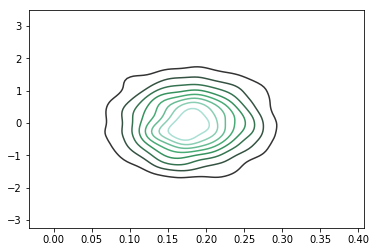

In [50]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

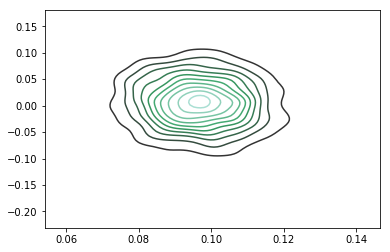

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [83]:
t = 10
# params[t]

In [84]:
np.mean(samples[:,t], axis=0)

array([[ 3.3247e-03, -7.3668e-03,  6.3002e-03,  1.1010e-02],
       [ 4.5848e-03, -3.7239e-04,  9.8147e-03,  3.6363e-03],
       [ 9.8738e-02, -1.8441e-03,  9.1986e-01,  1.1776e-04]])

In [85]:
np.std(samples[:,t], axis=0)

array([[0.0571, 0.032 , 0.0175, 0.0123],
       [0.0097, 0.0084, 0.0086, 0.0065],
       [0.0108, 0.0047, 0.024 , 0.003 ]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


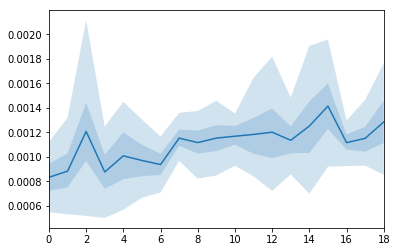

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


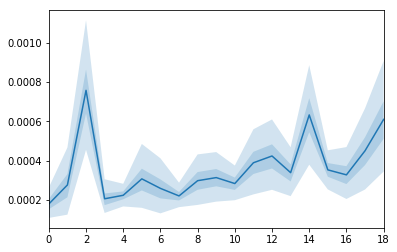

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


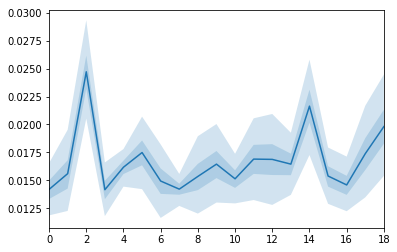

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()